# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
#from jax import numpy as np
import numpy as np
import pickle
import math

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from calibrate import calibrate
from utils import read_diagrams, create_labeled_classes, bin_class_loss, multi_class_loss, bin_class_acc, multi_class_acc

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Uncomment if you do not want to access GPU
#os.environ["JAX_PLATFORMS"] = "cpu"

BATCH_SIZE = 64
EPOCHS = 10000
SEED = 0

## Select workload

Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "small"
#workload = "medium"
#workload = "large"

classification = 2
layers = 1
single_qubit_params = 3
n_wire_count = 2
loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

## Read circuits

We read the circuits from the pickled files.

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training, validation and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Prepare circuits for the Lambeq optimizer

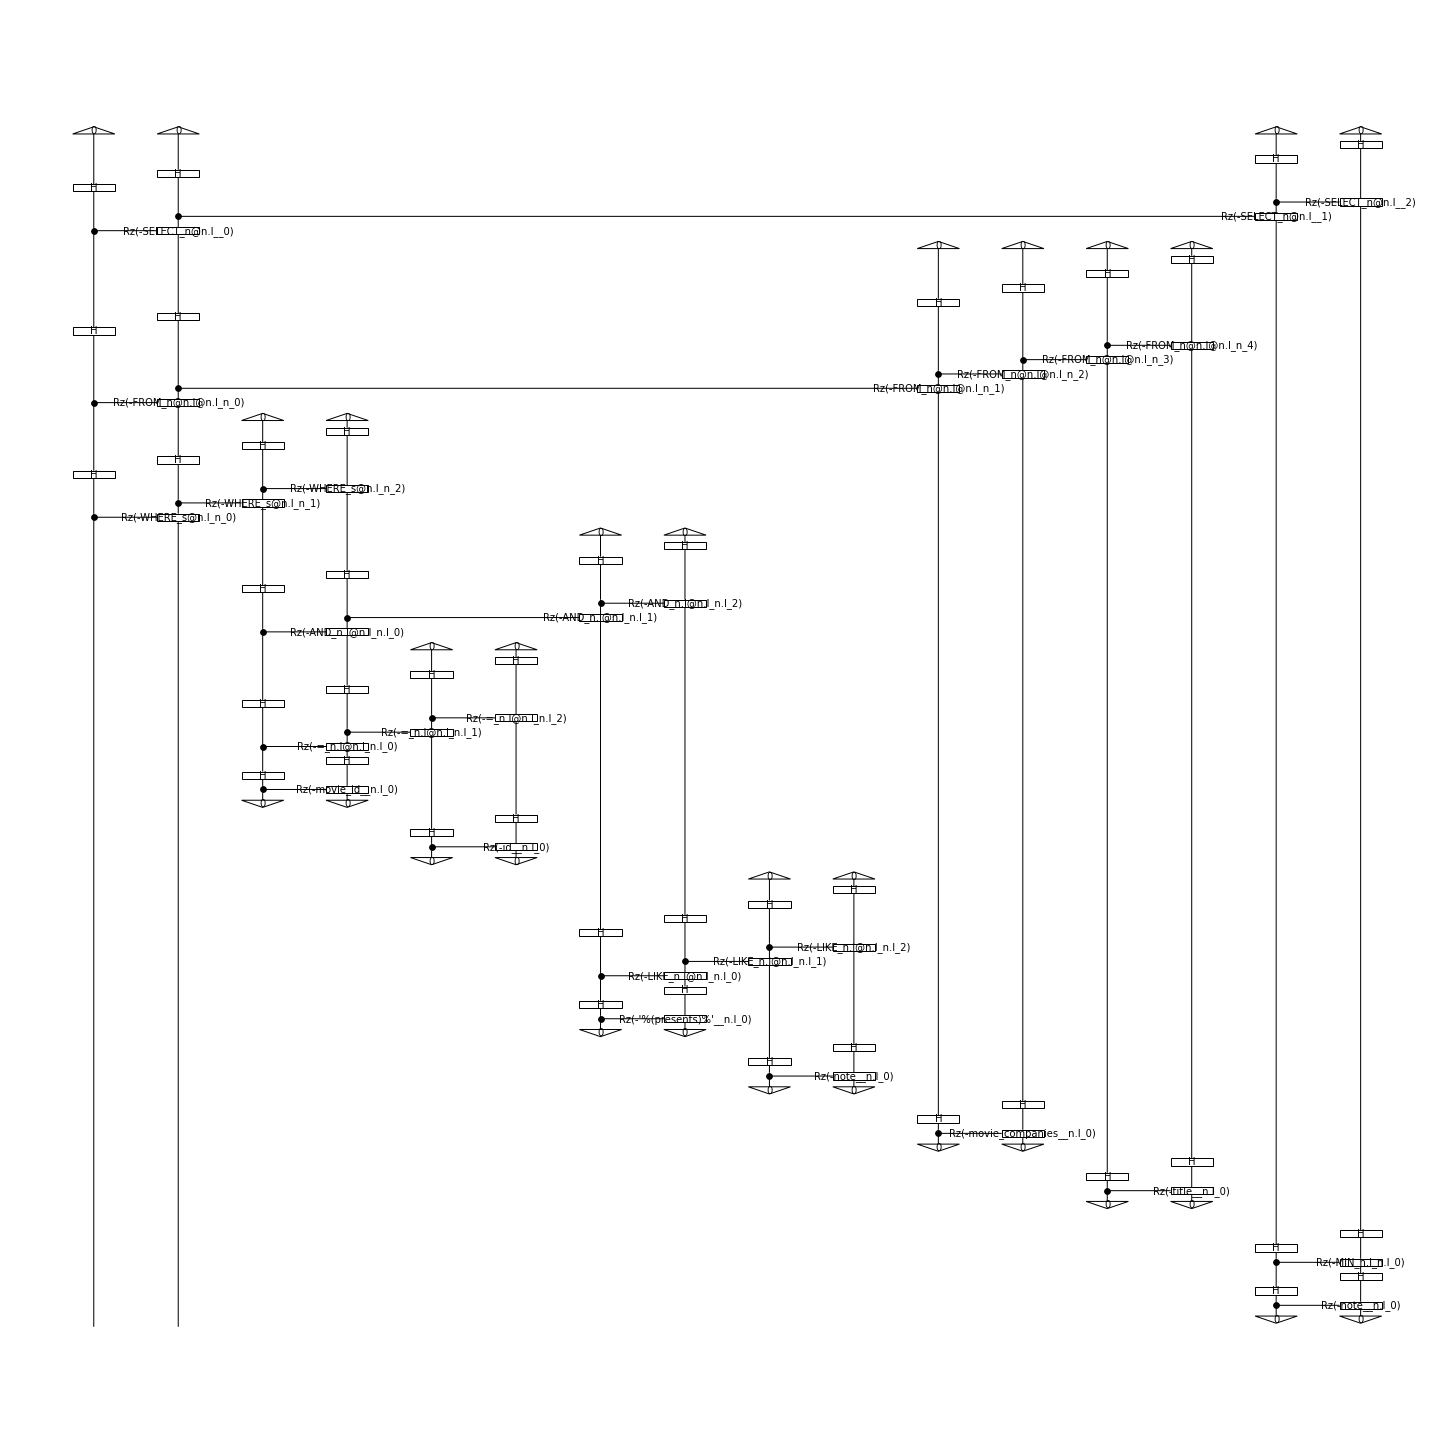

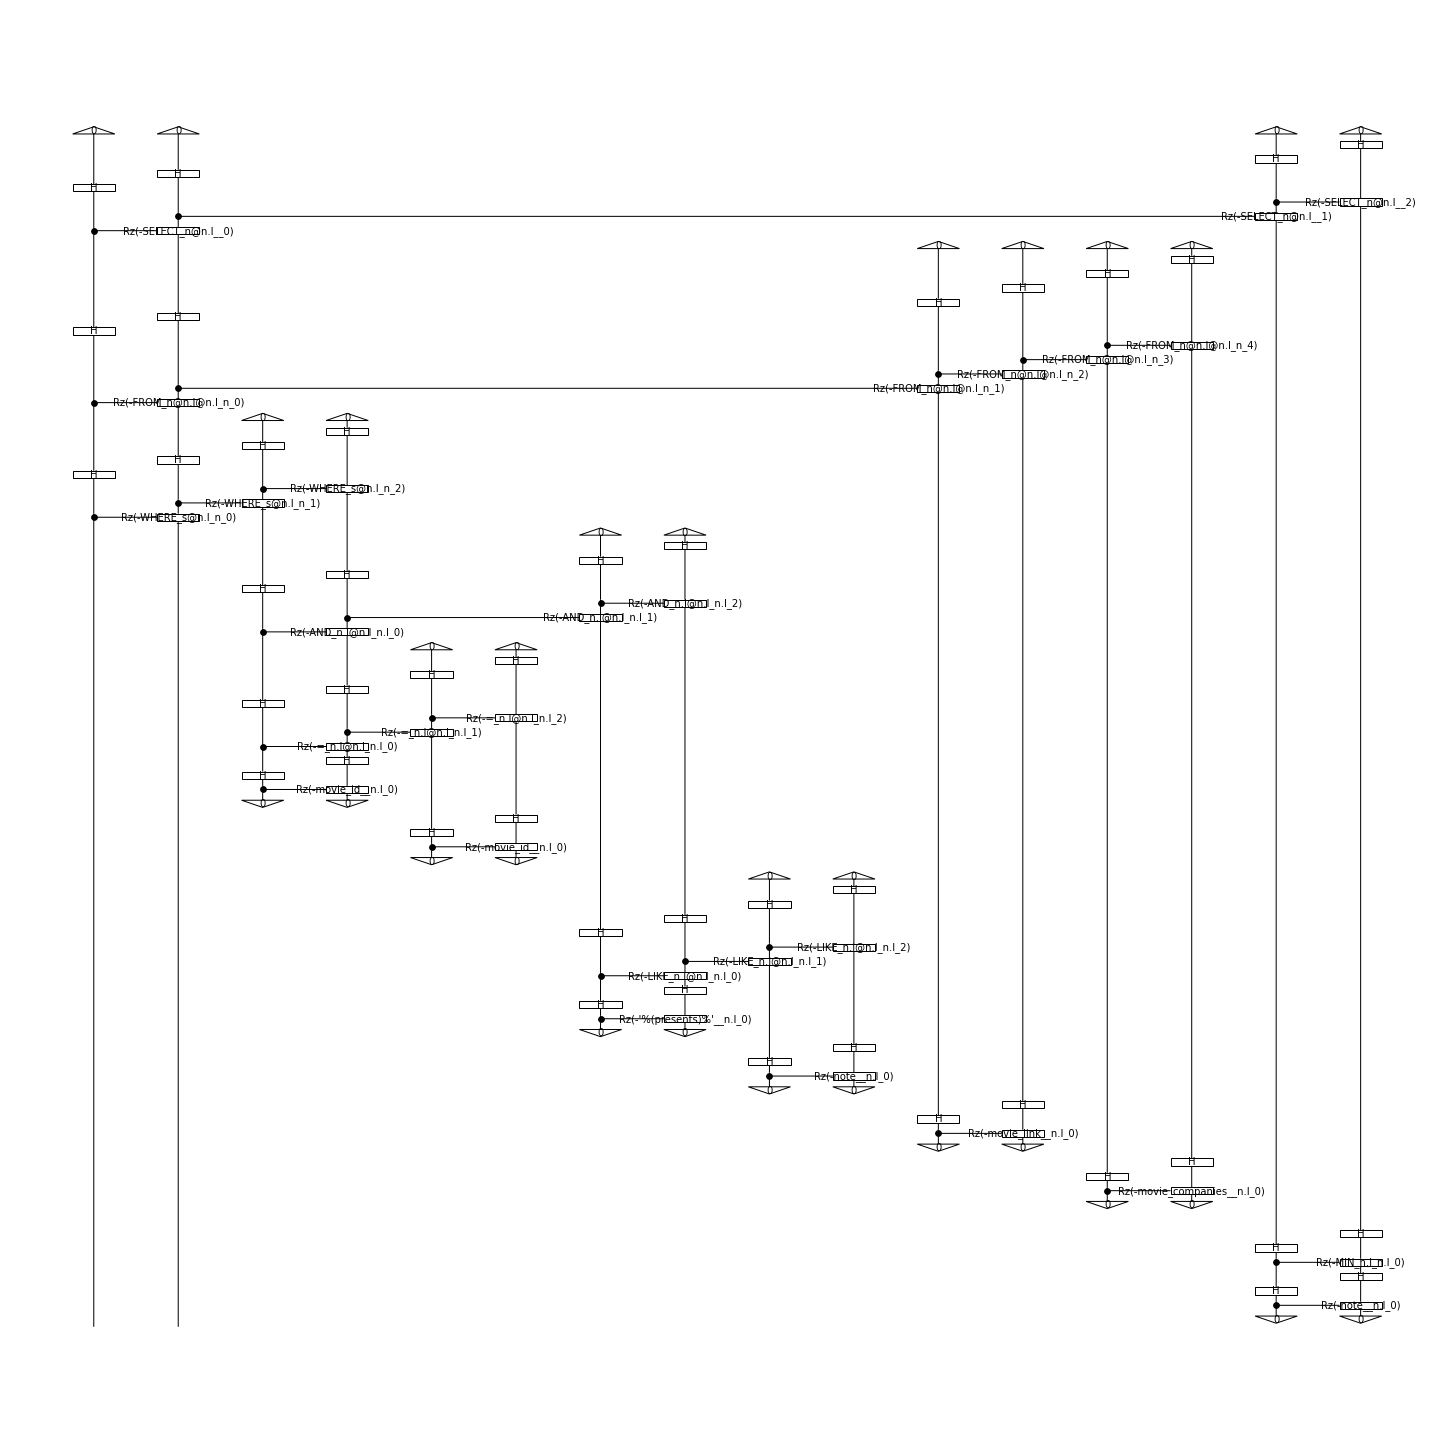

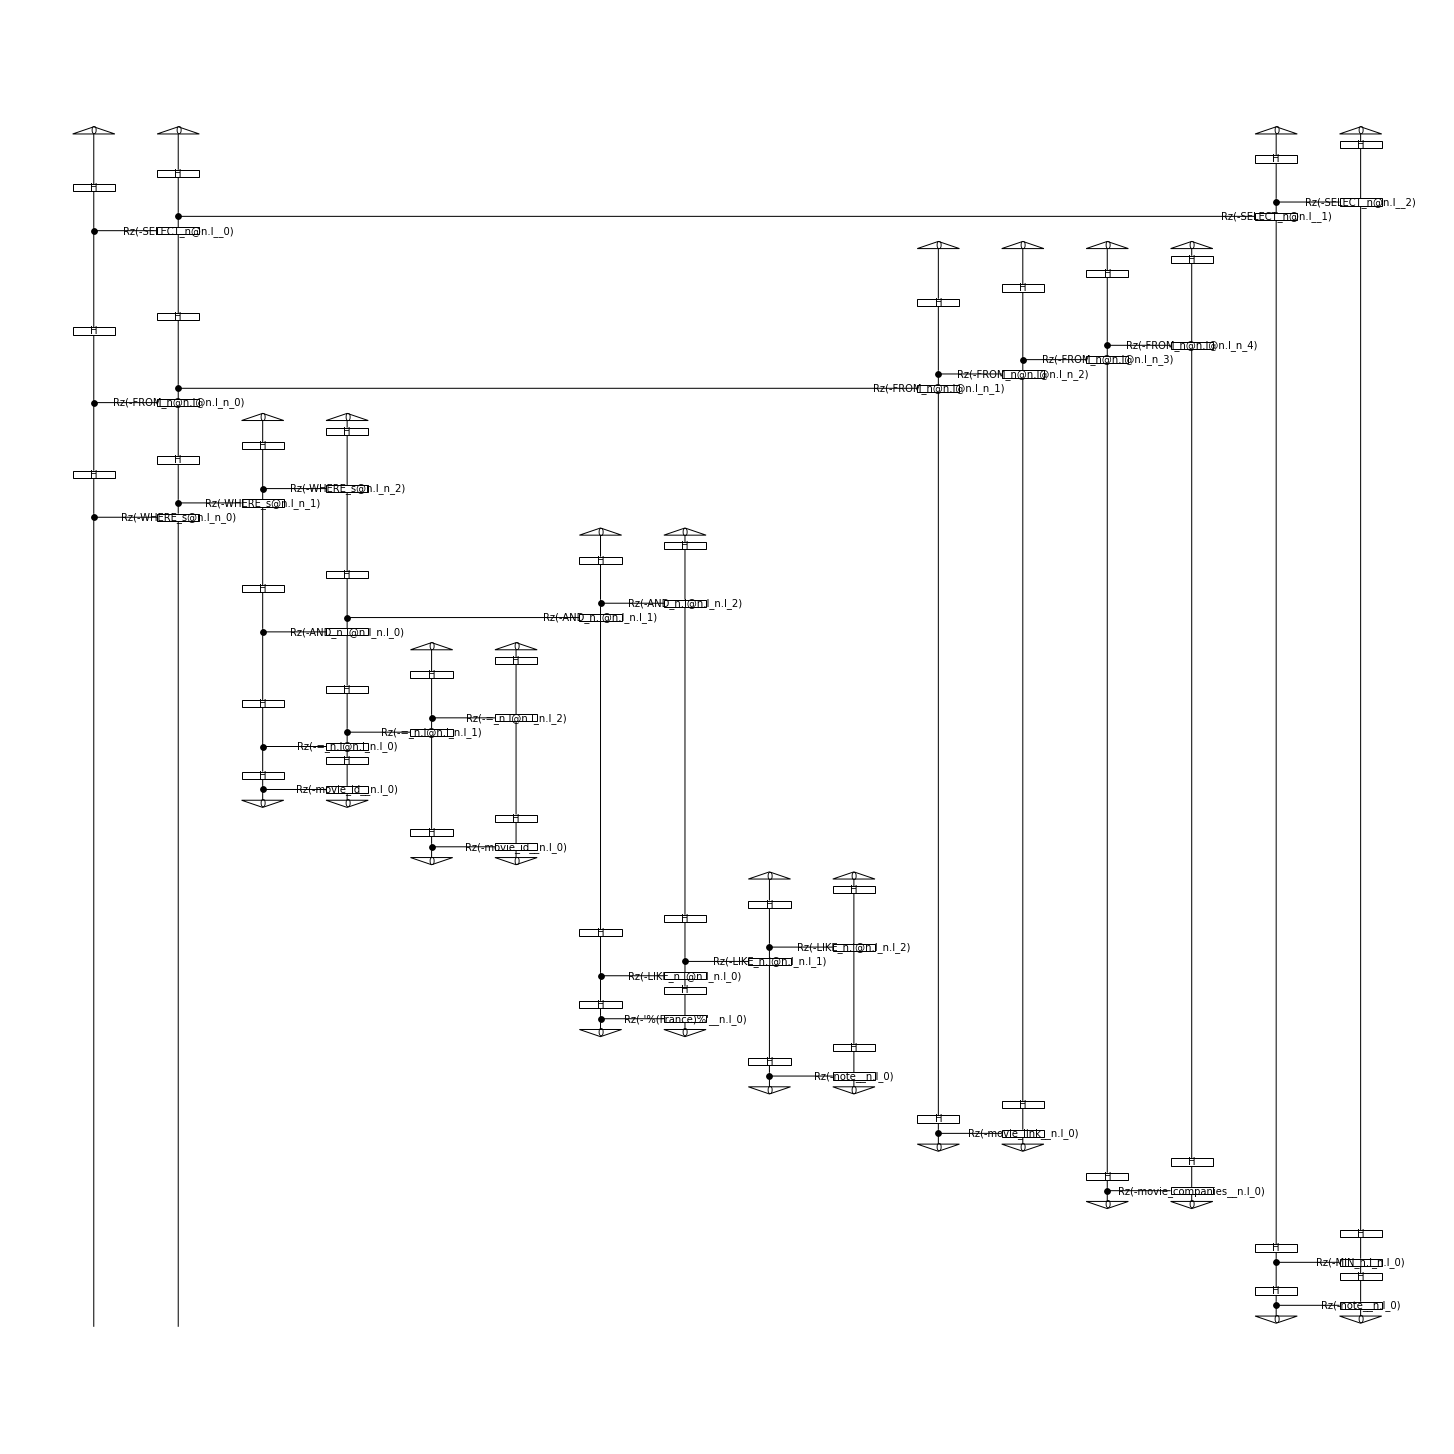

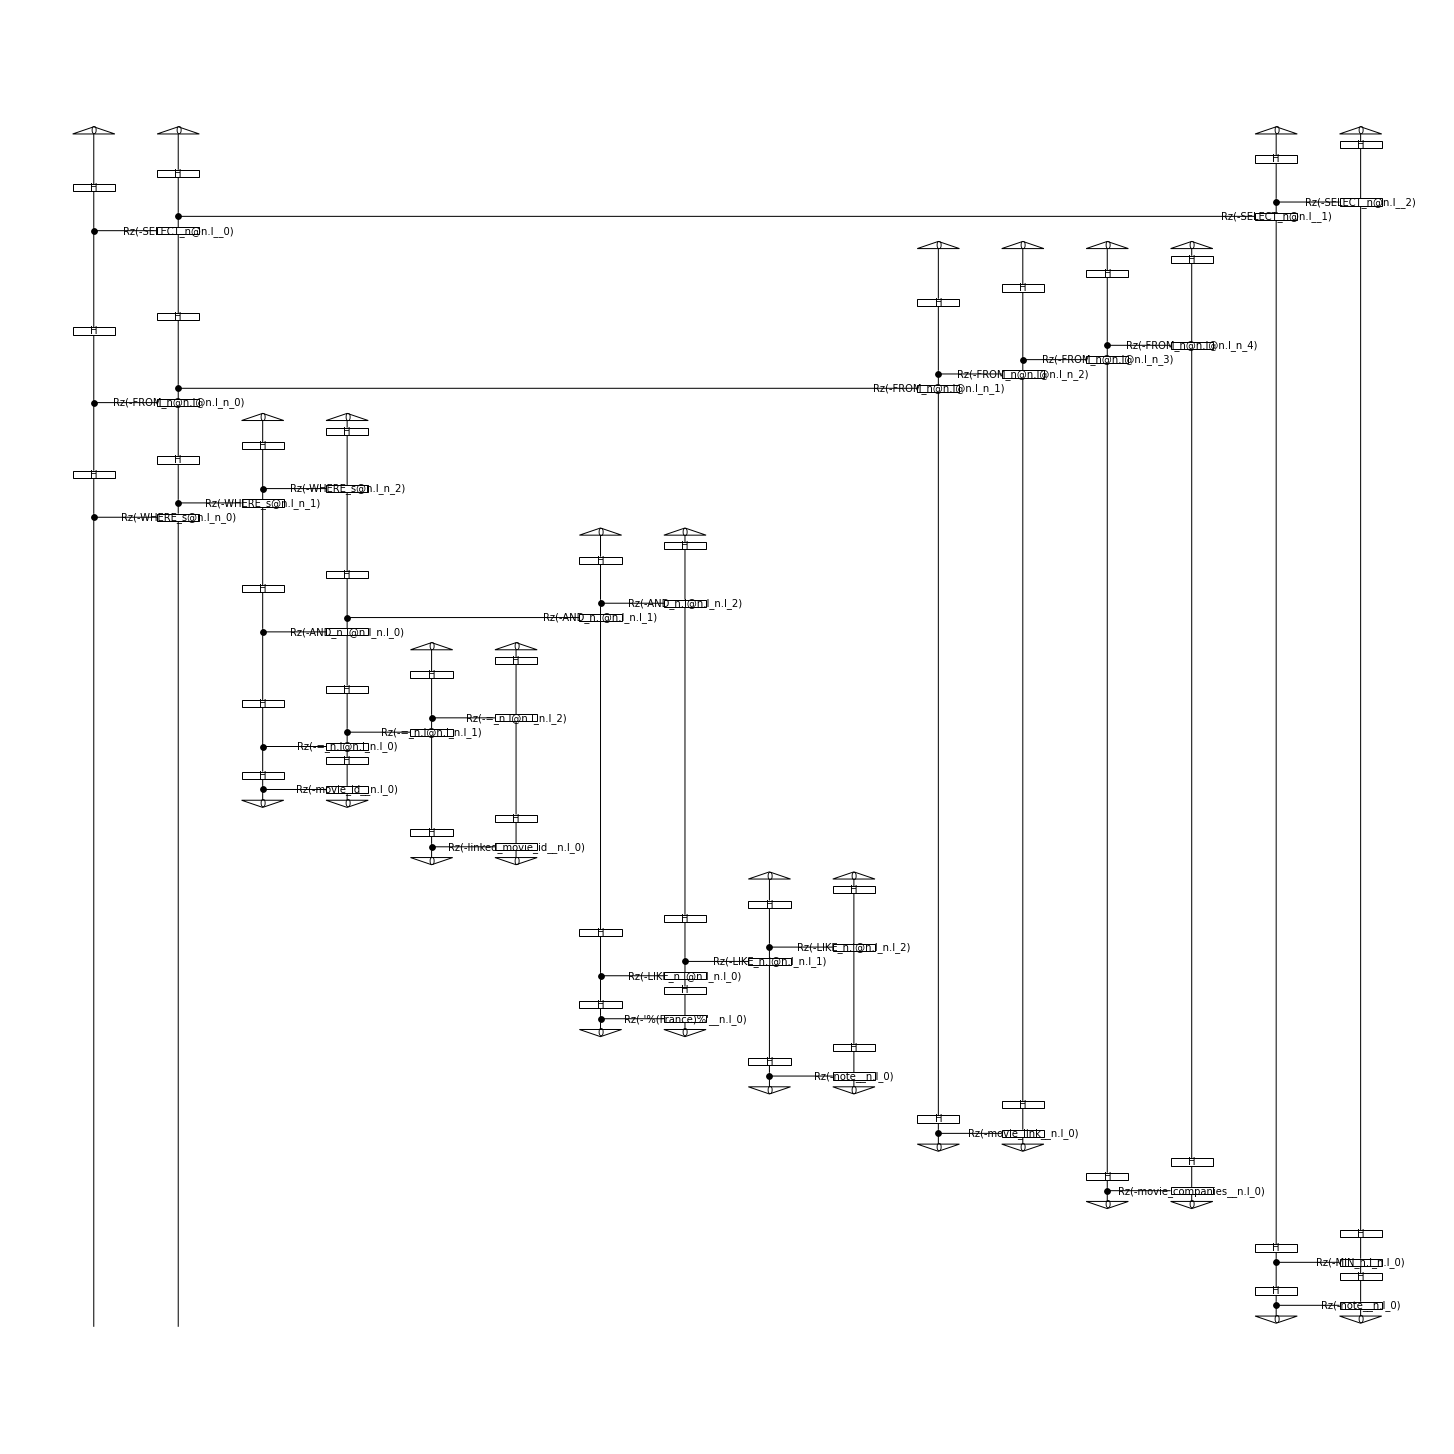

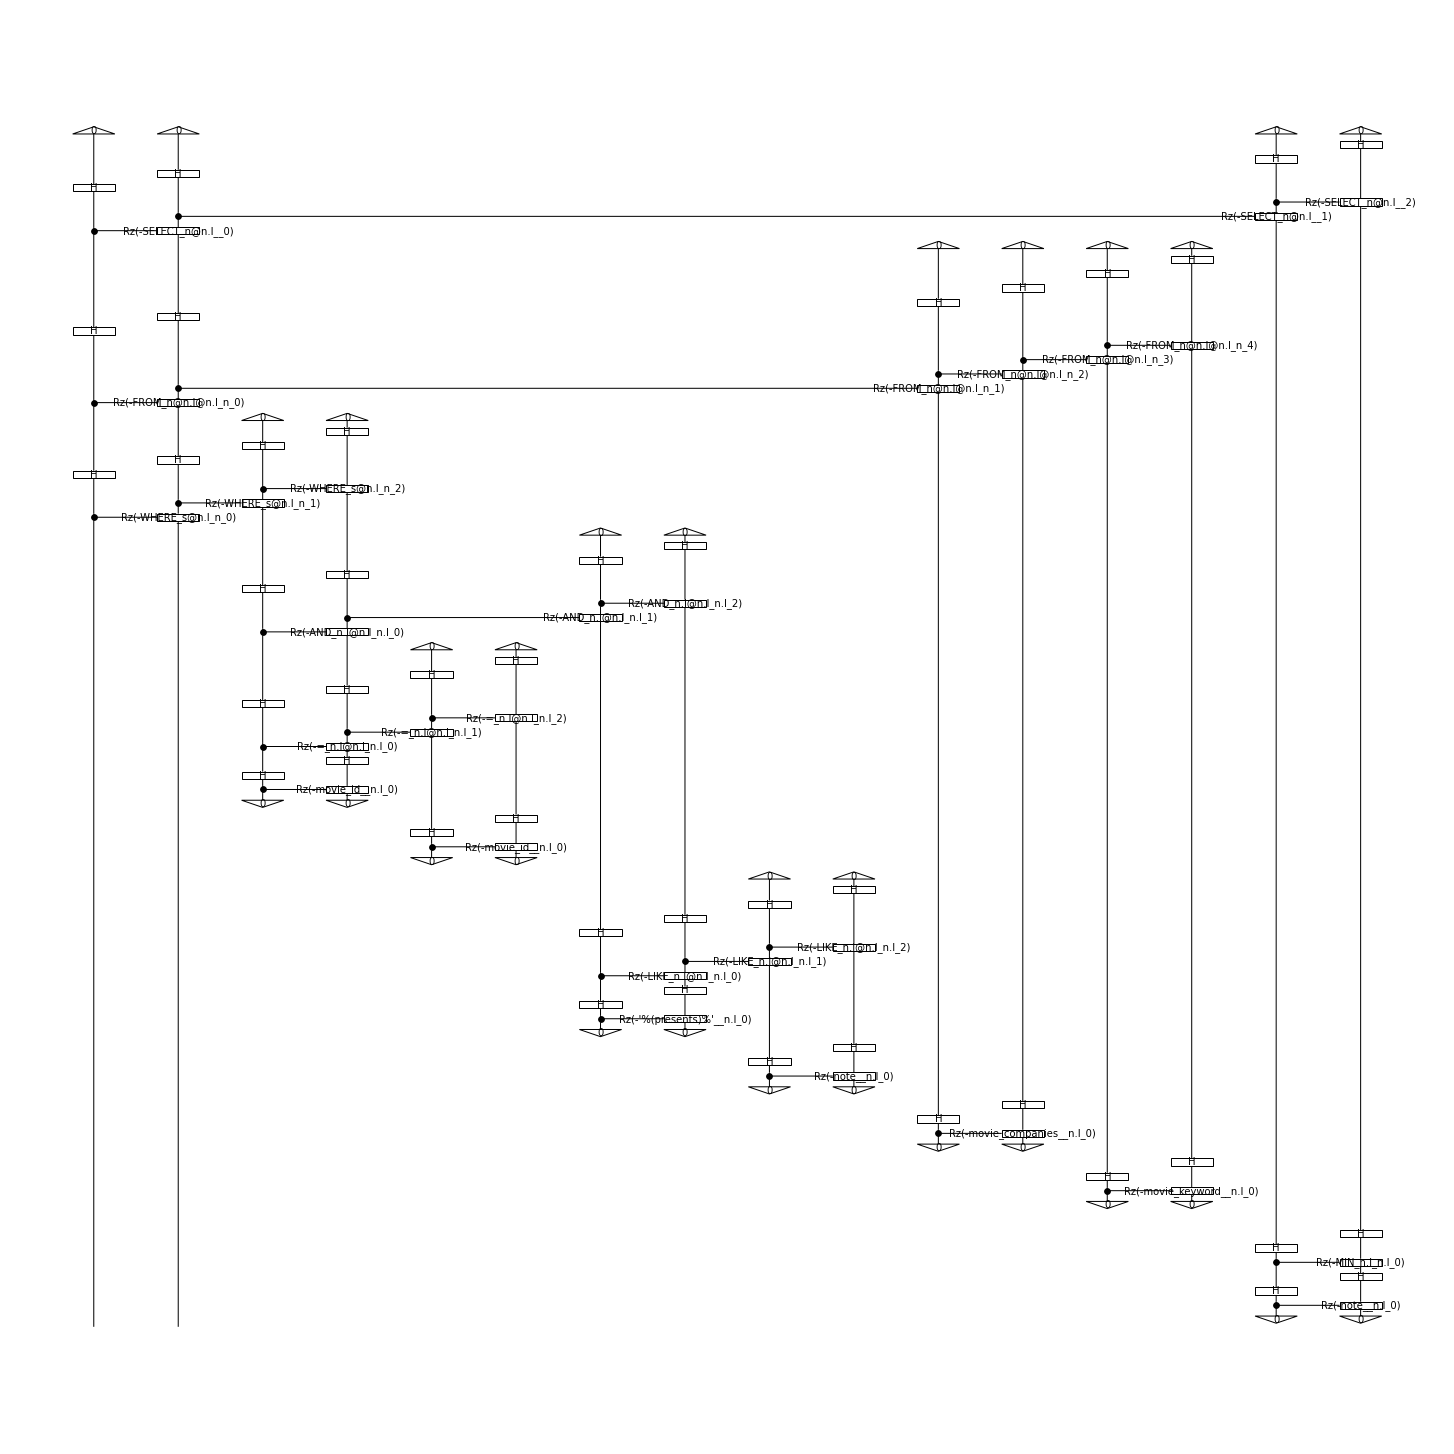

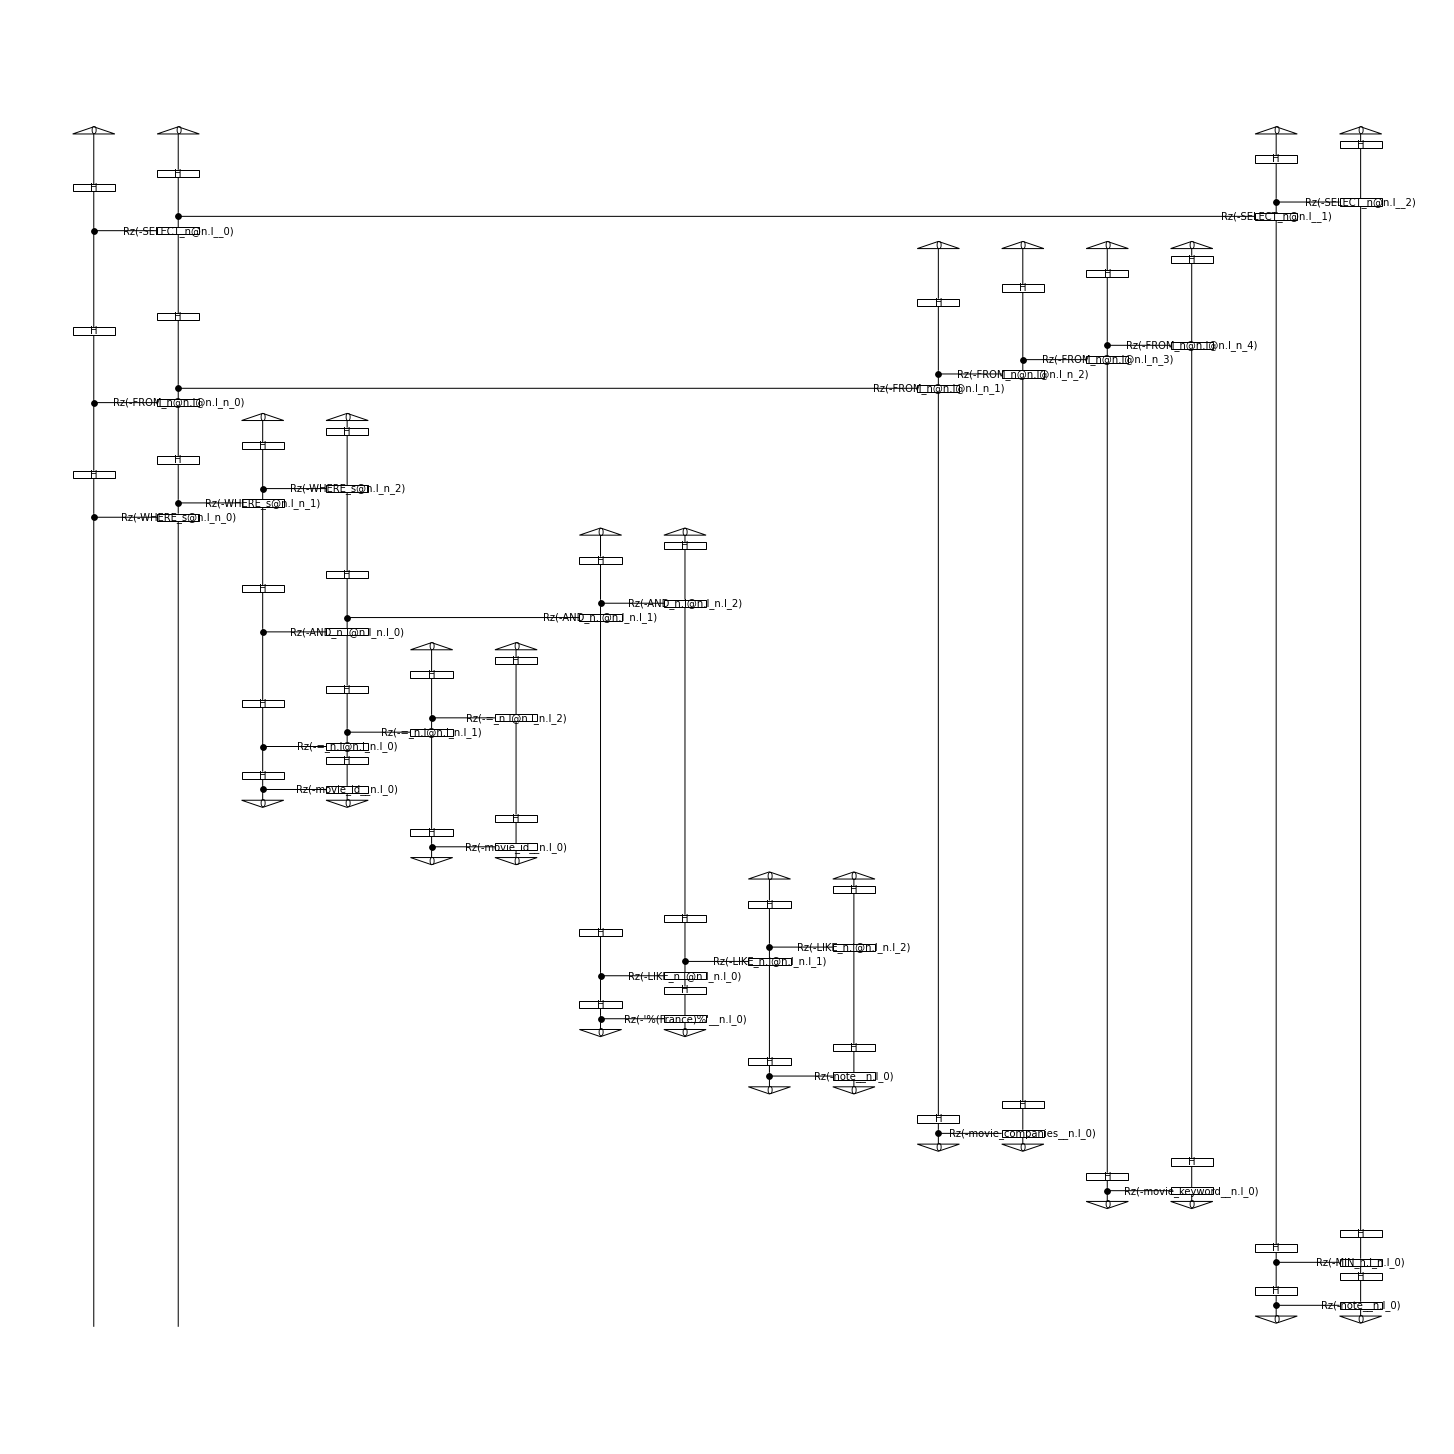

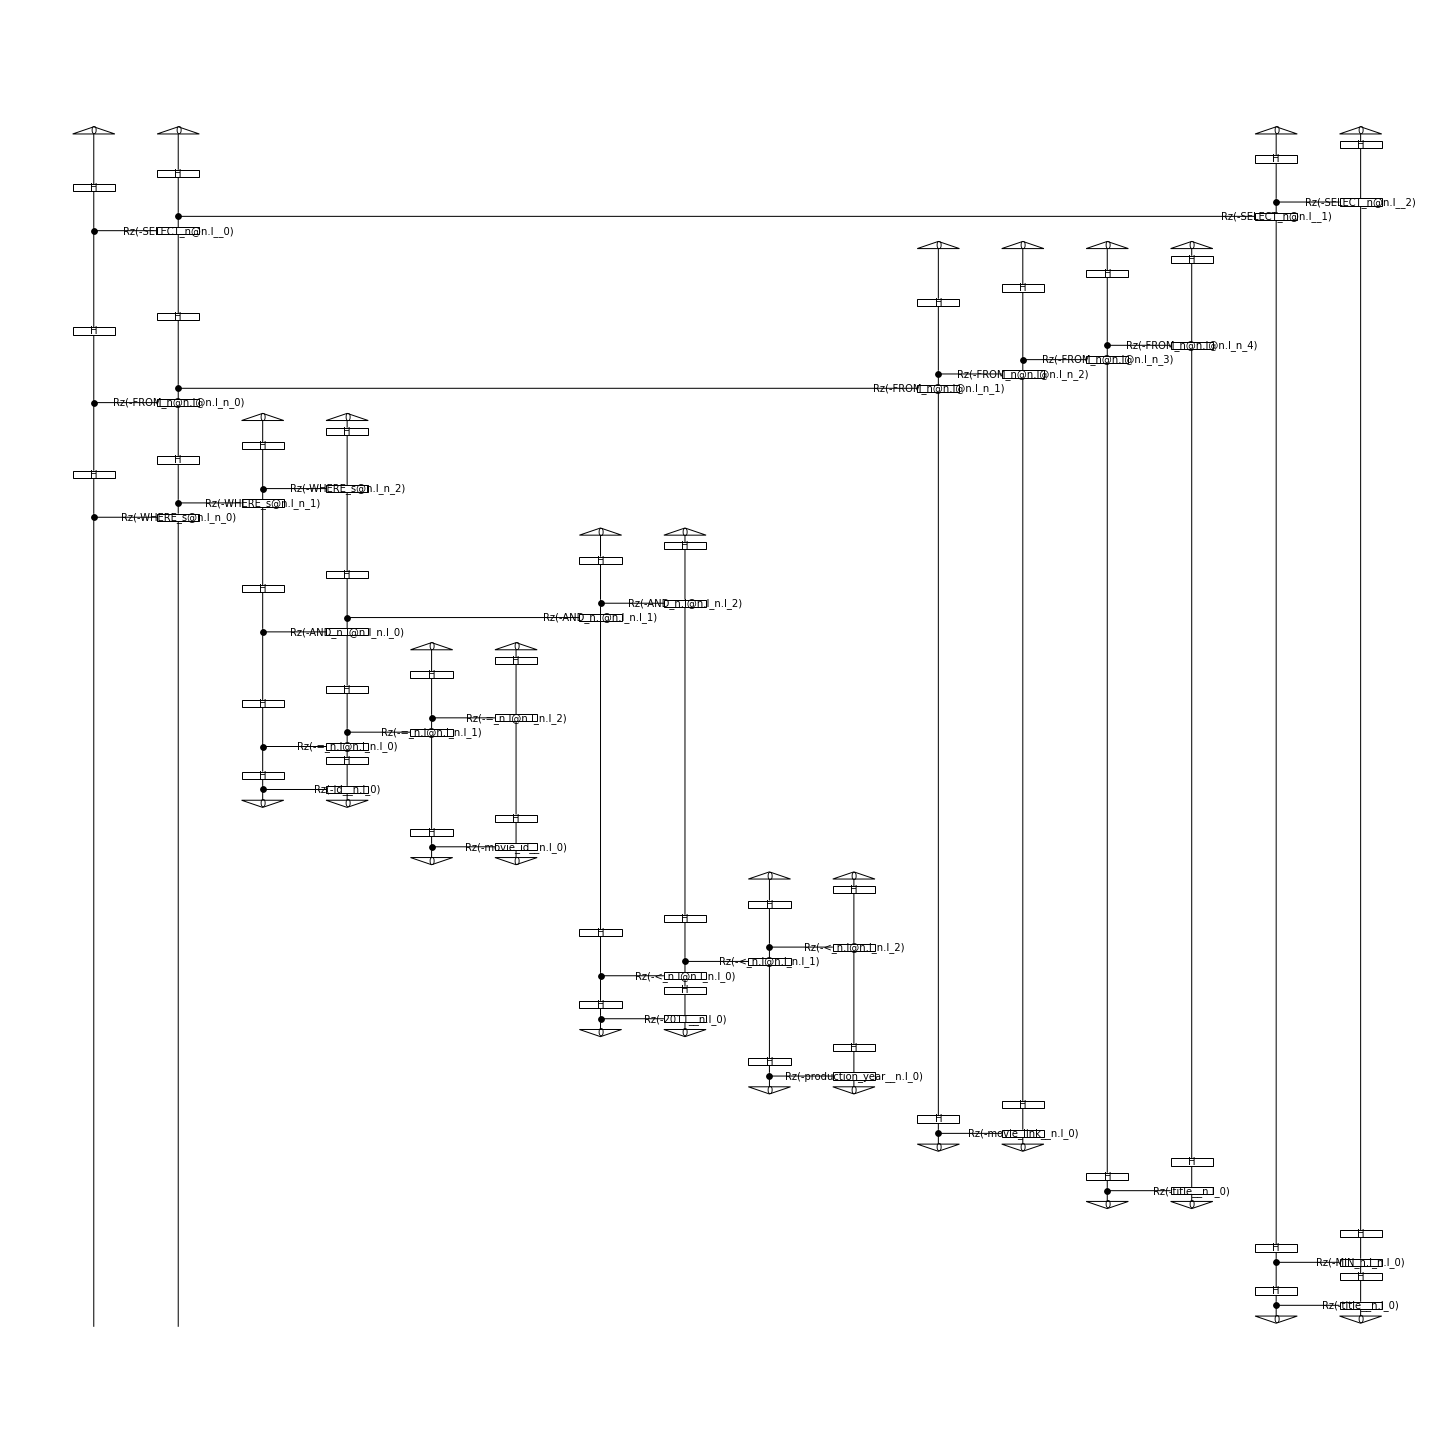

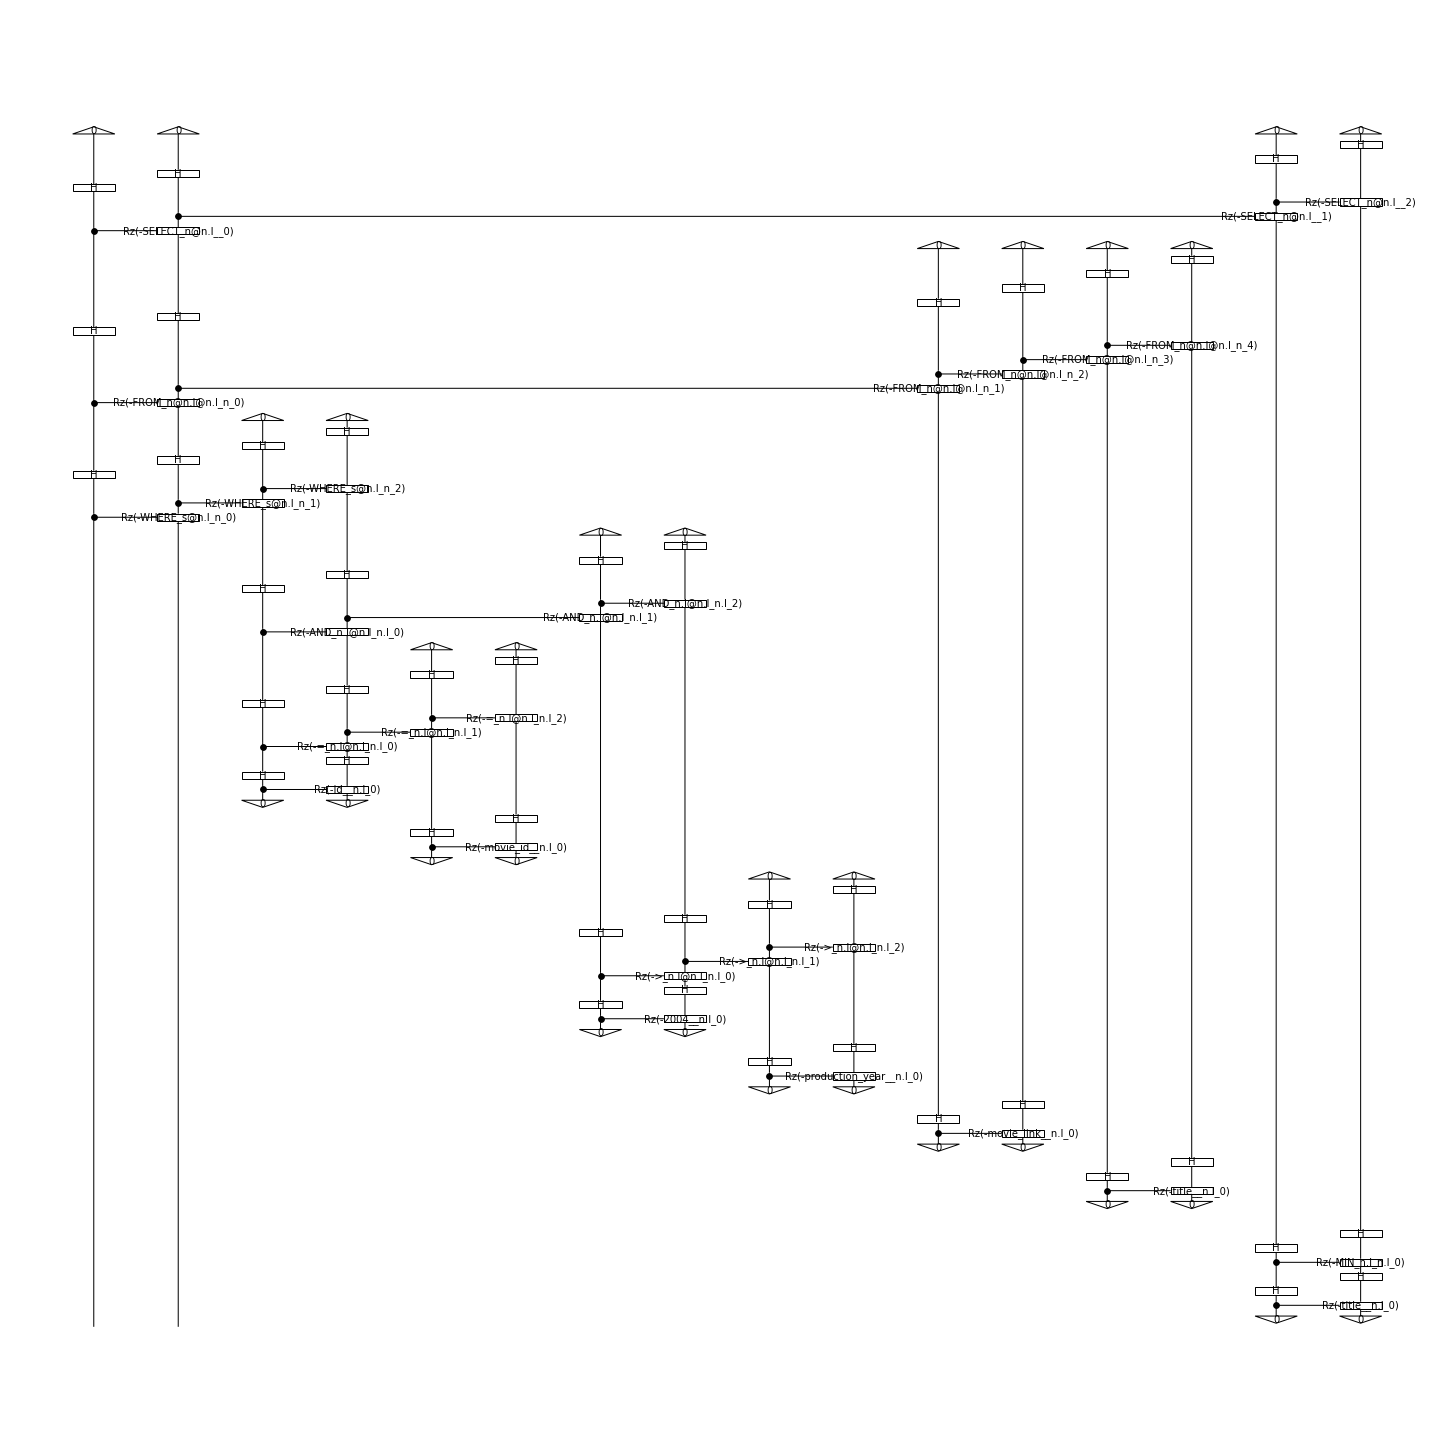

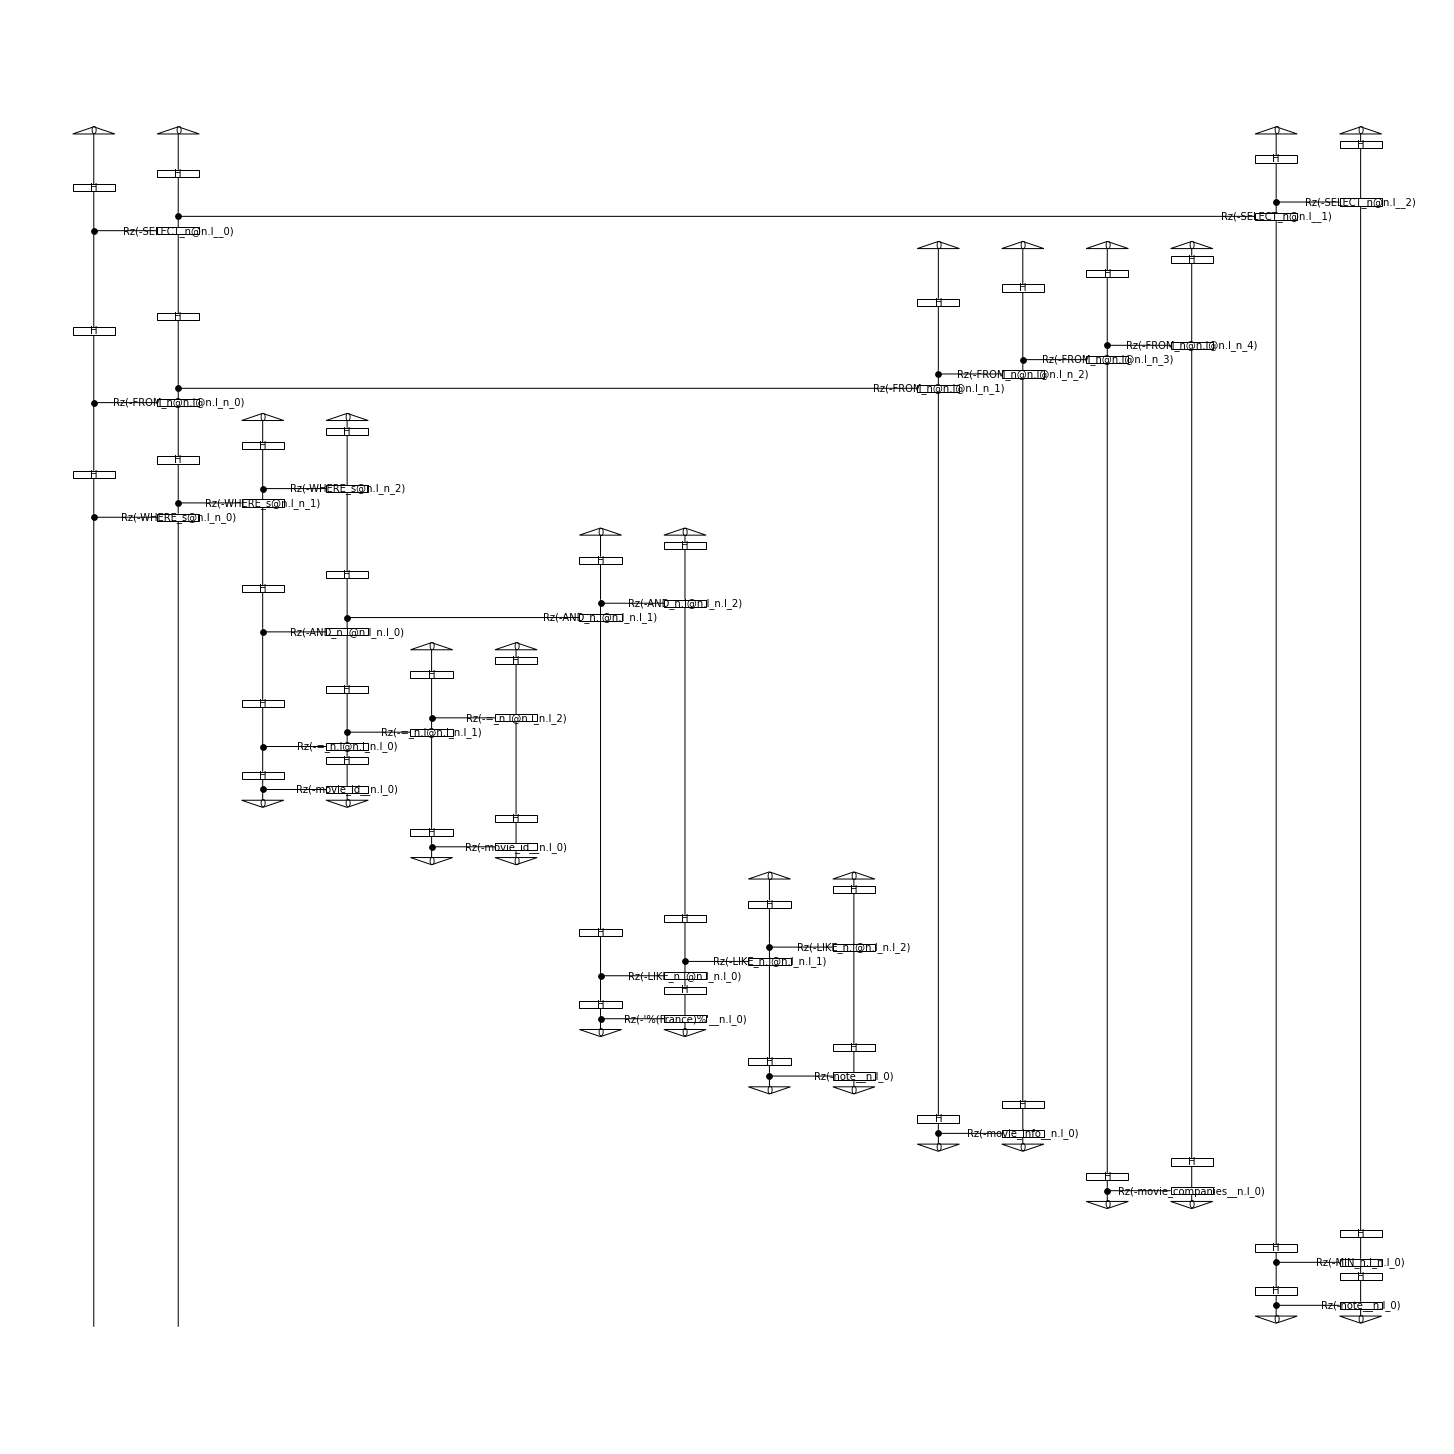

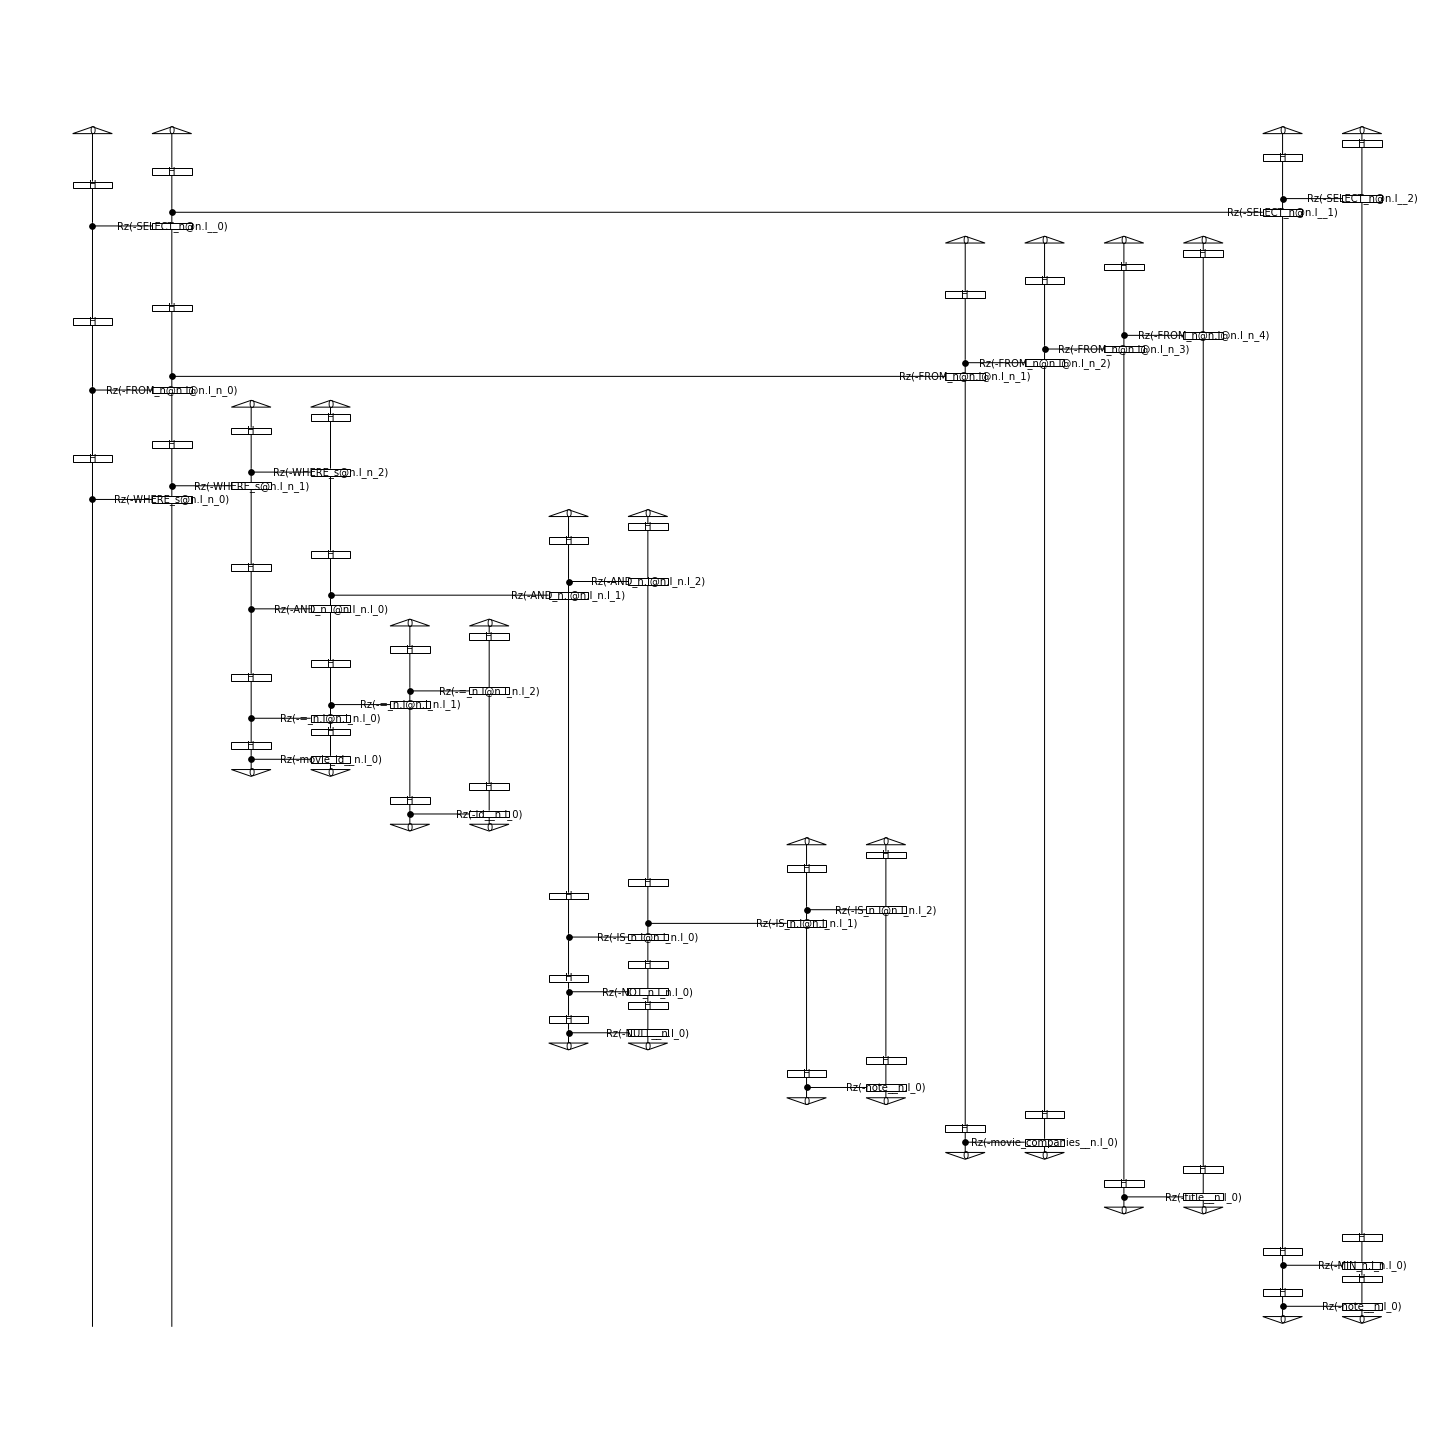

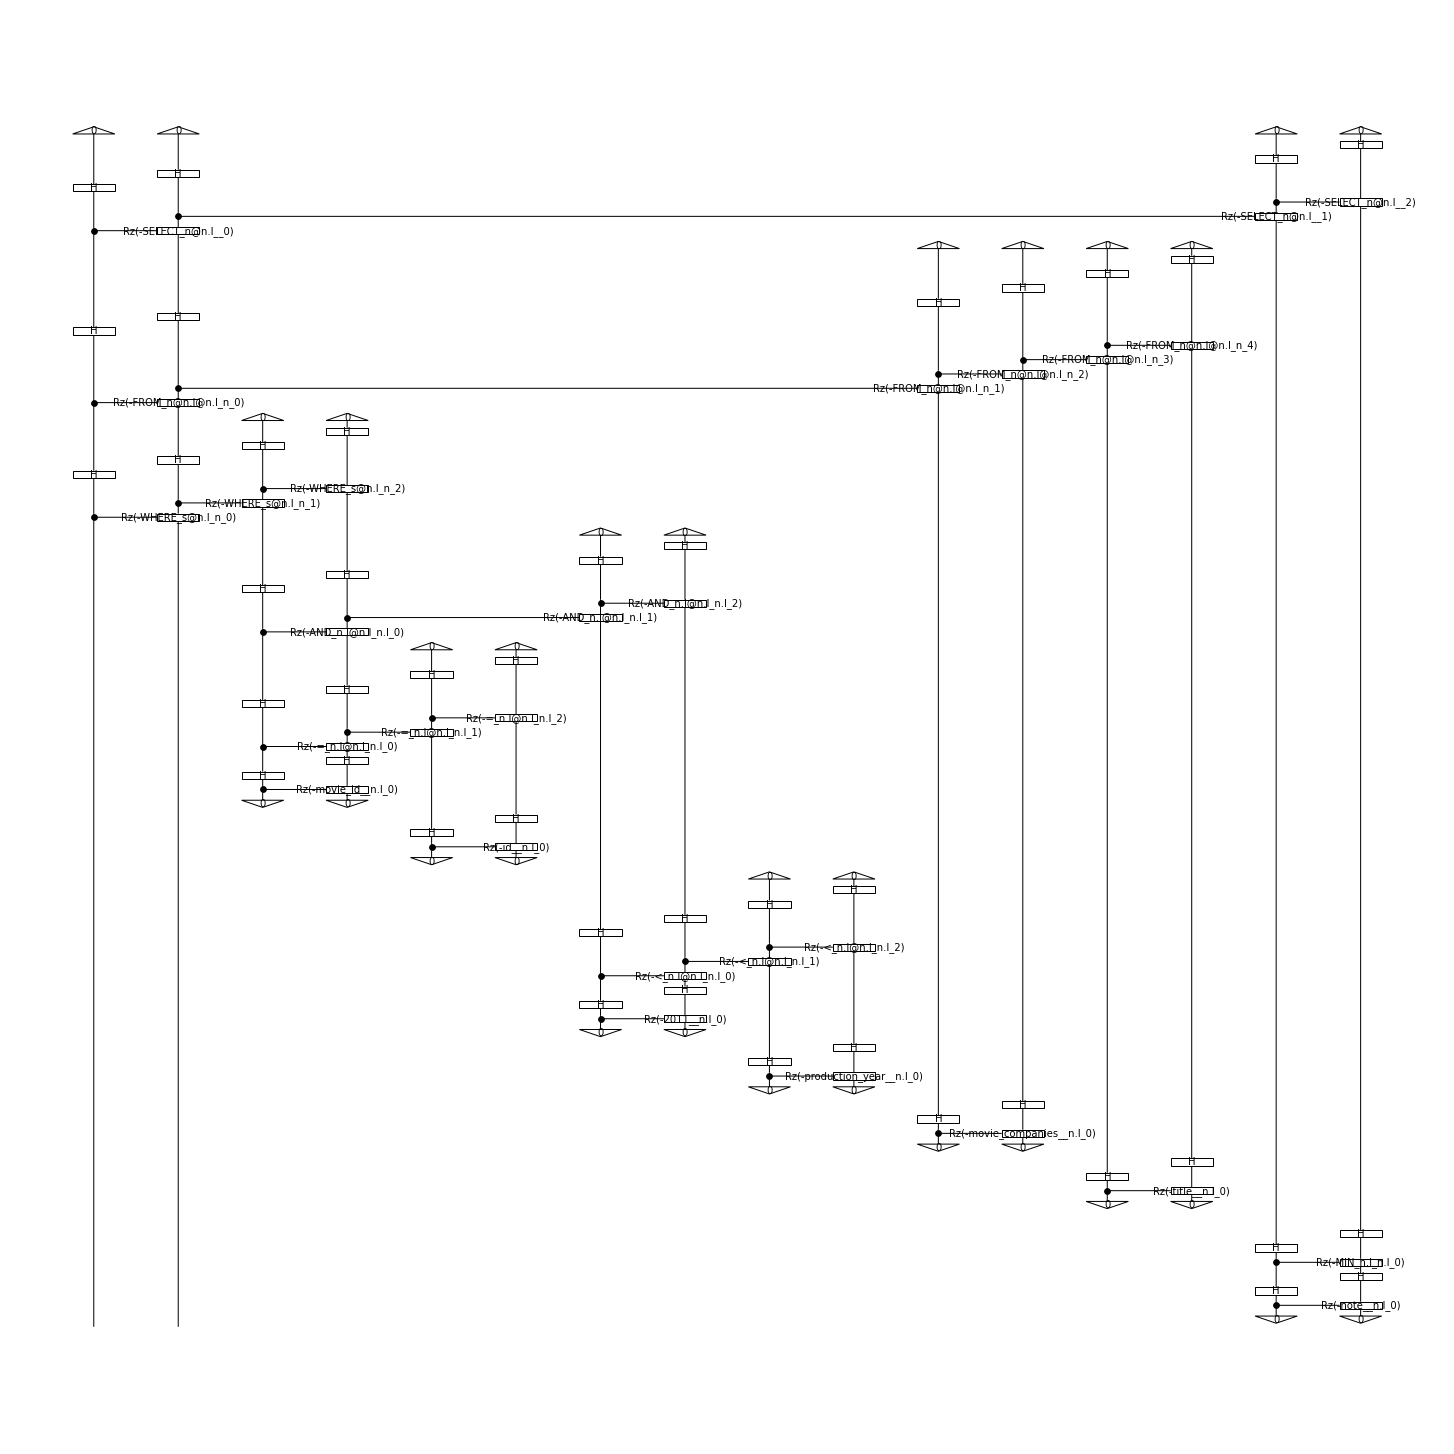

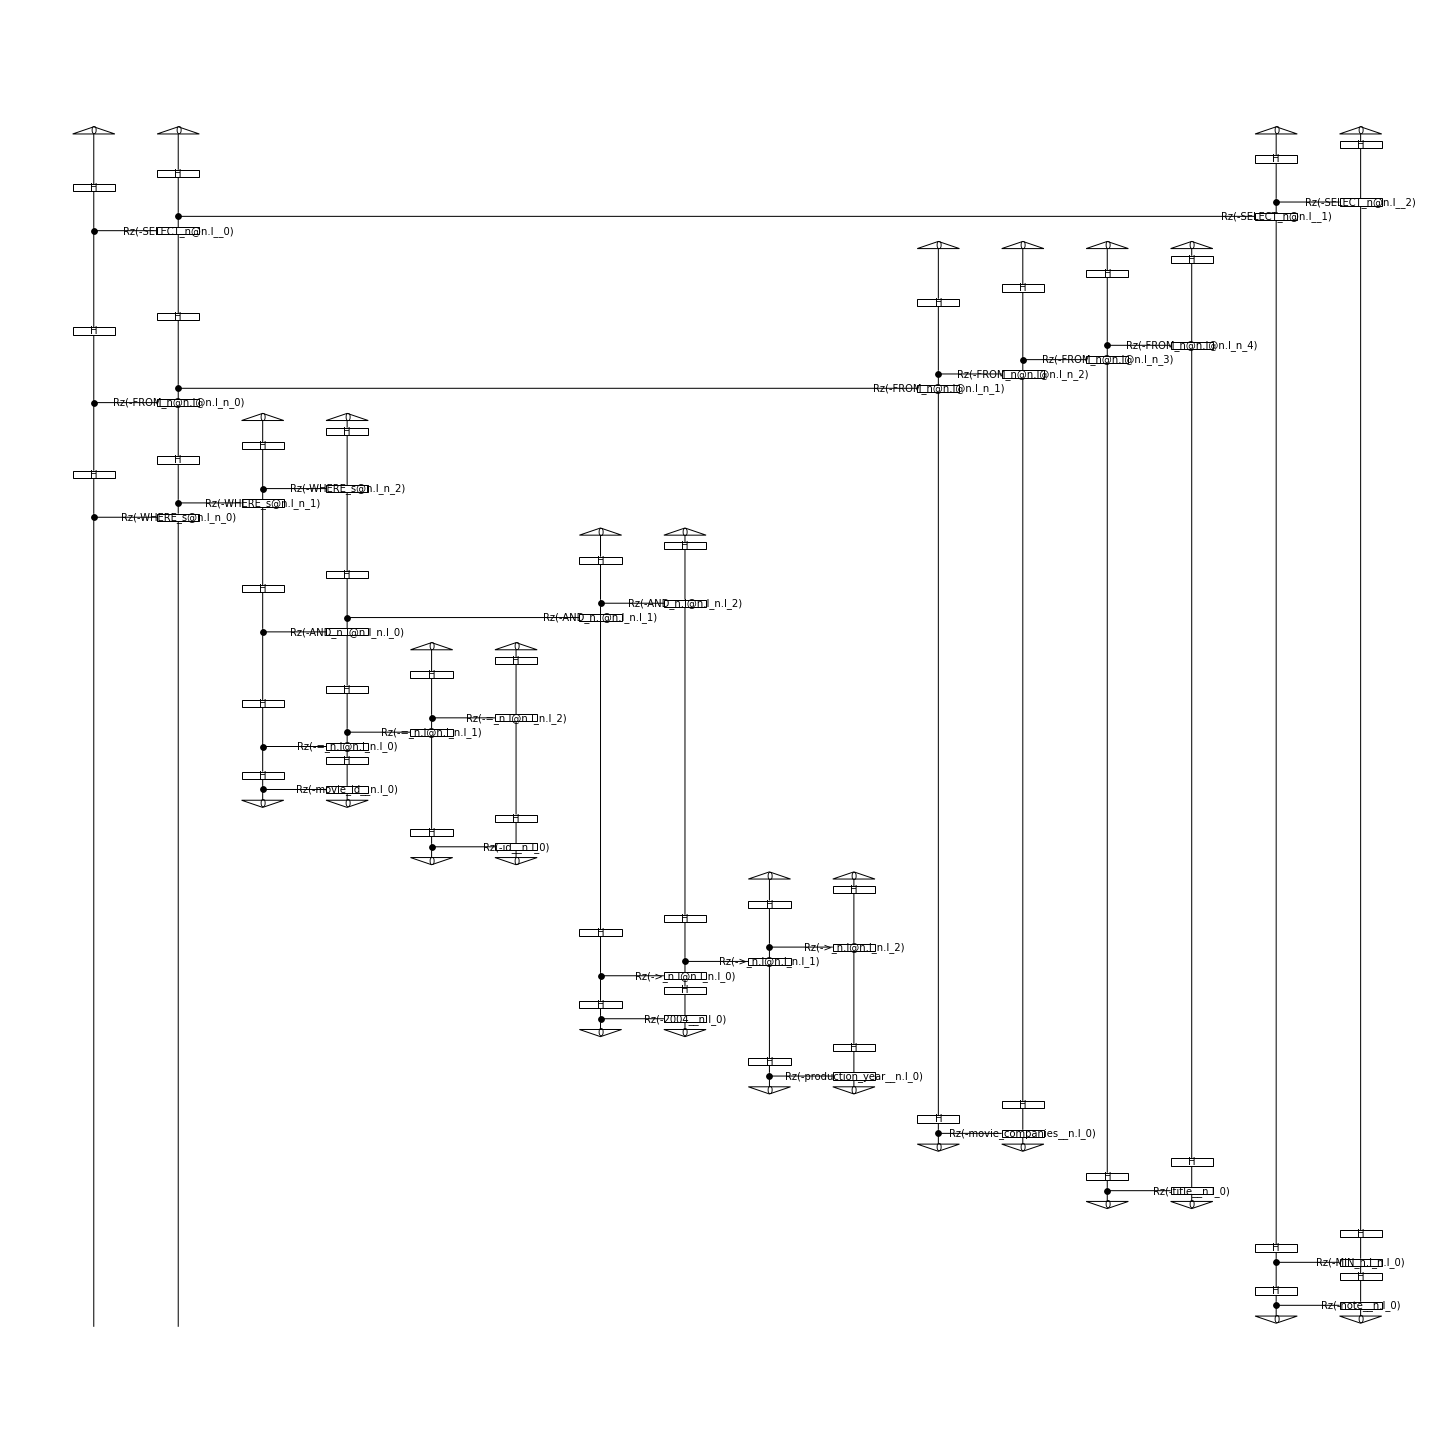

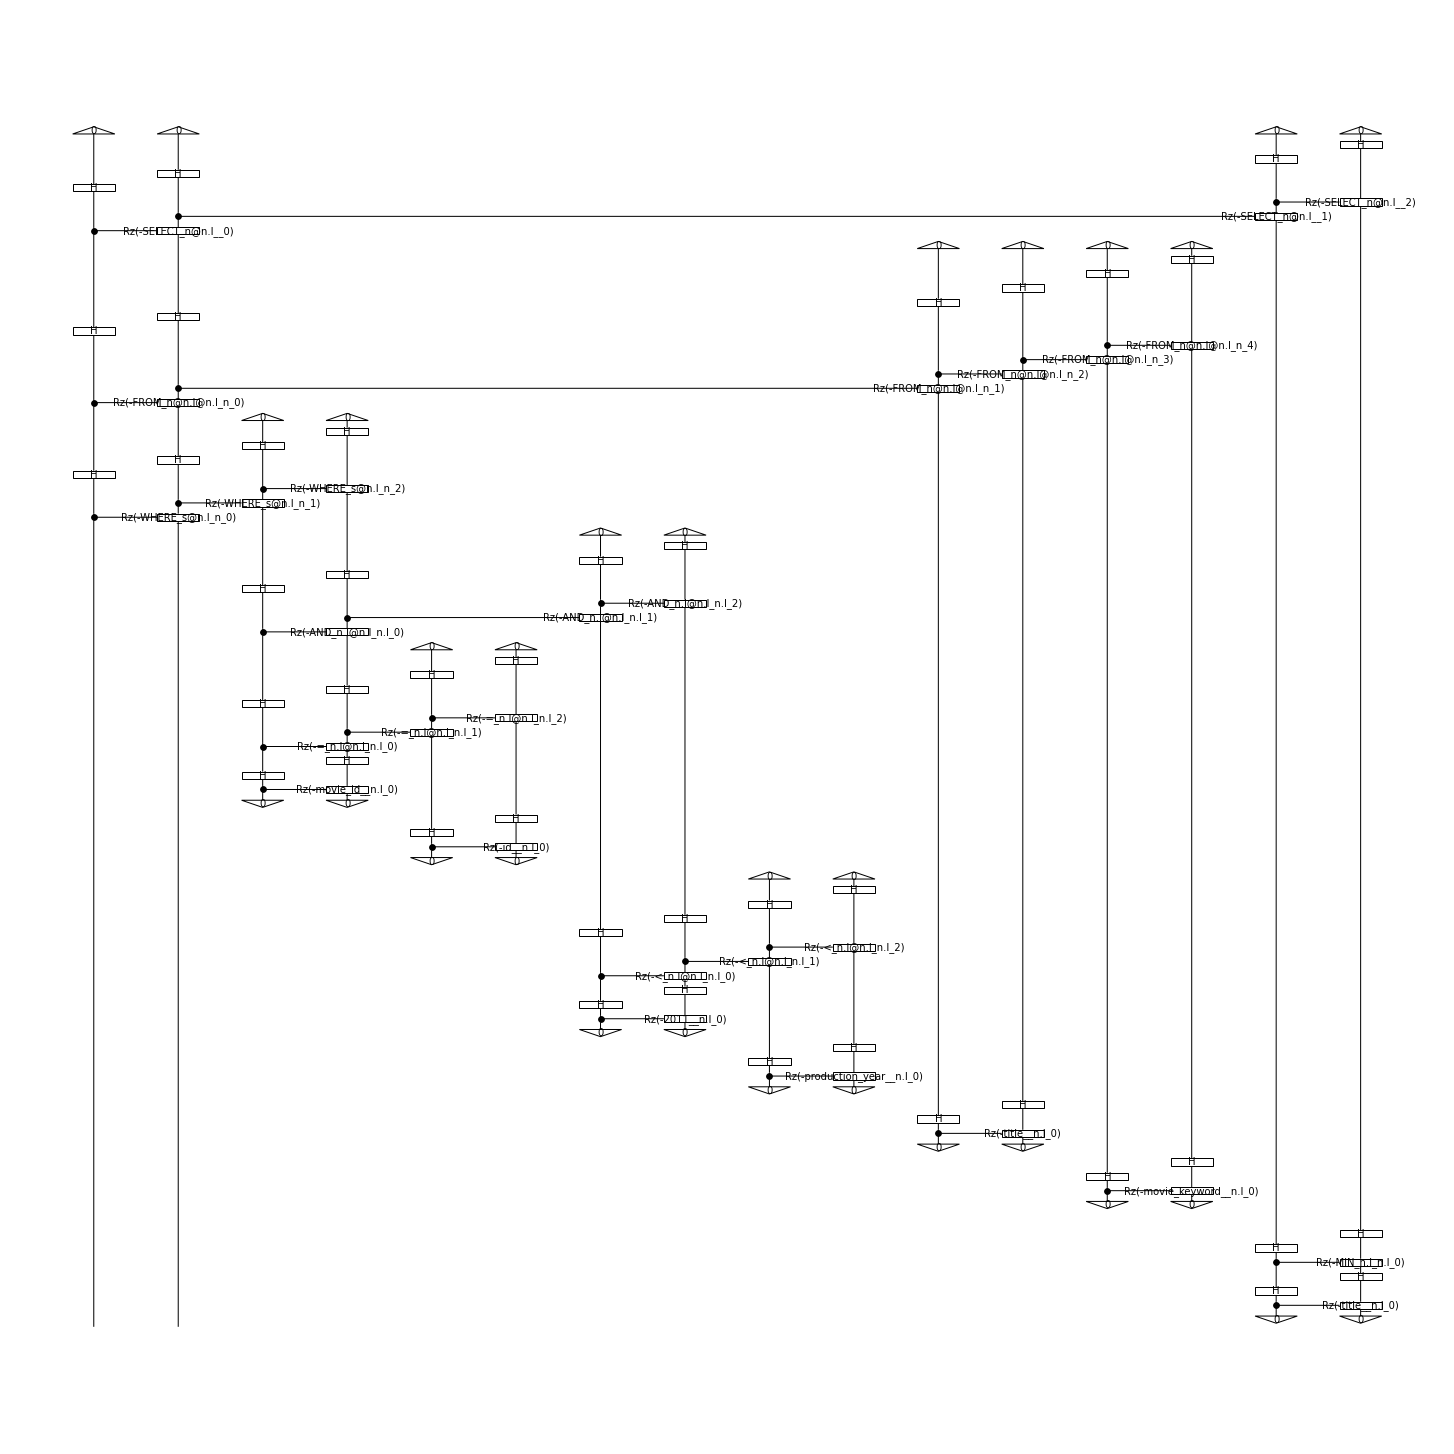

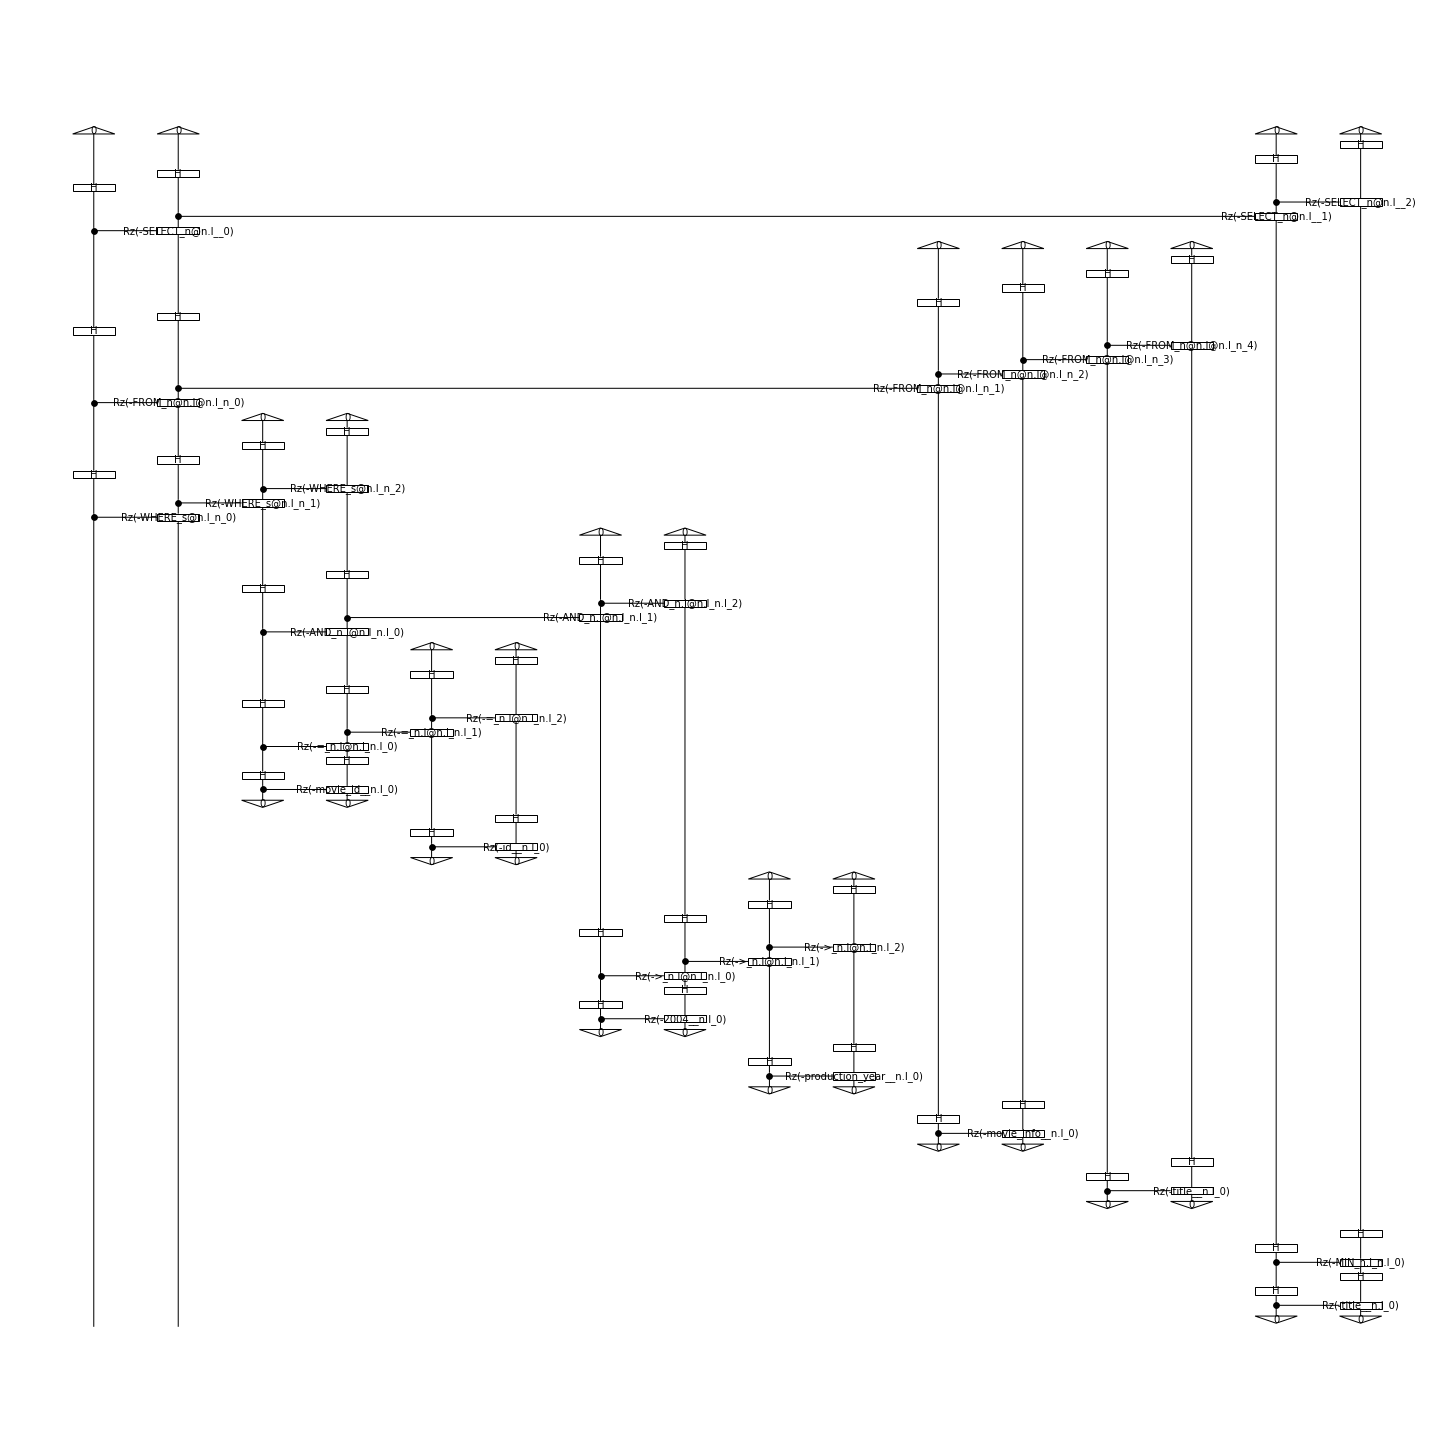

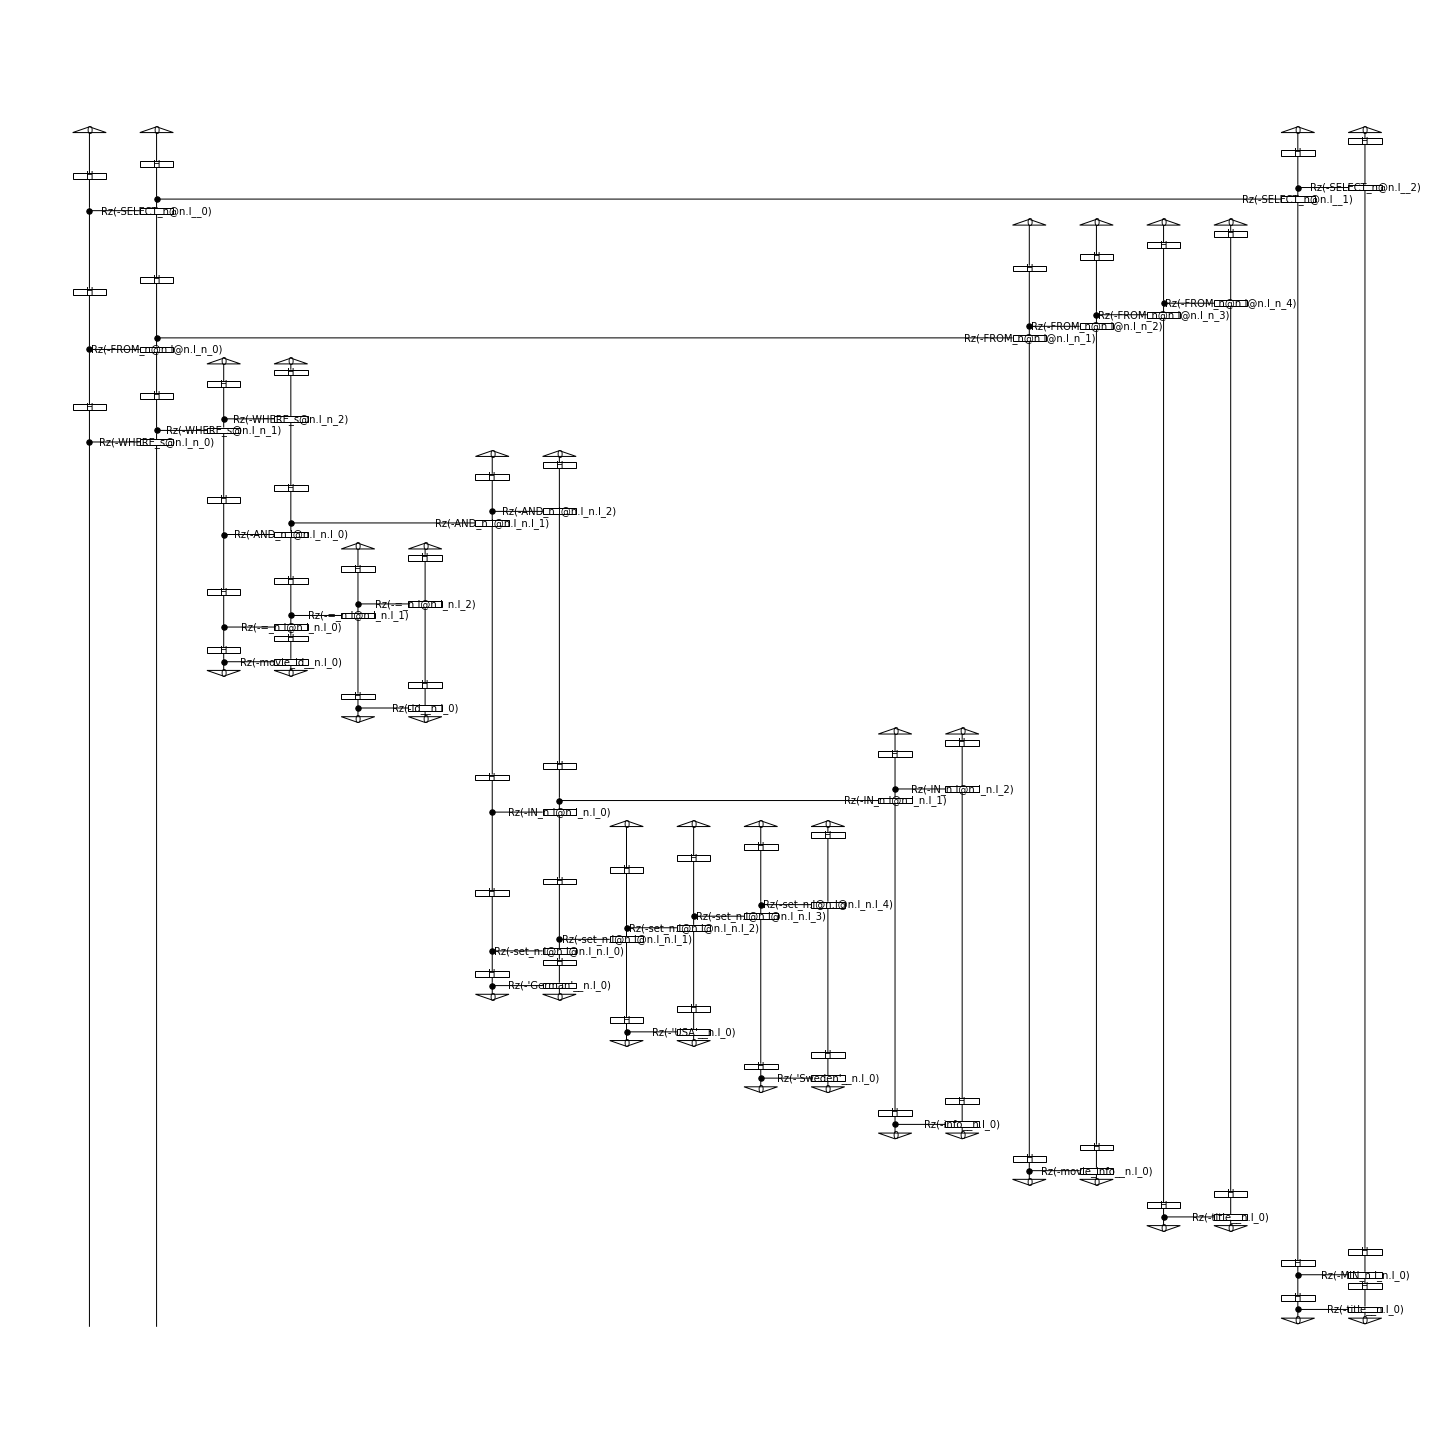

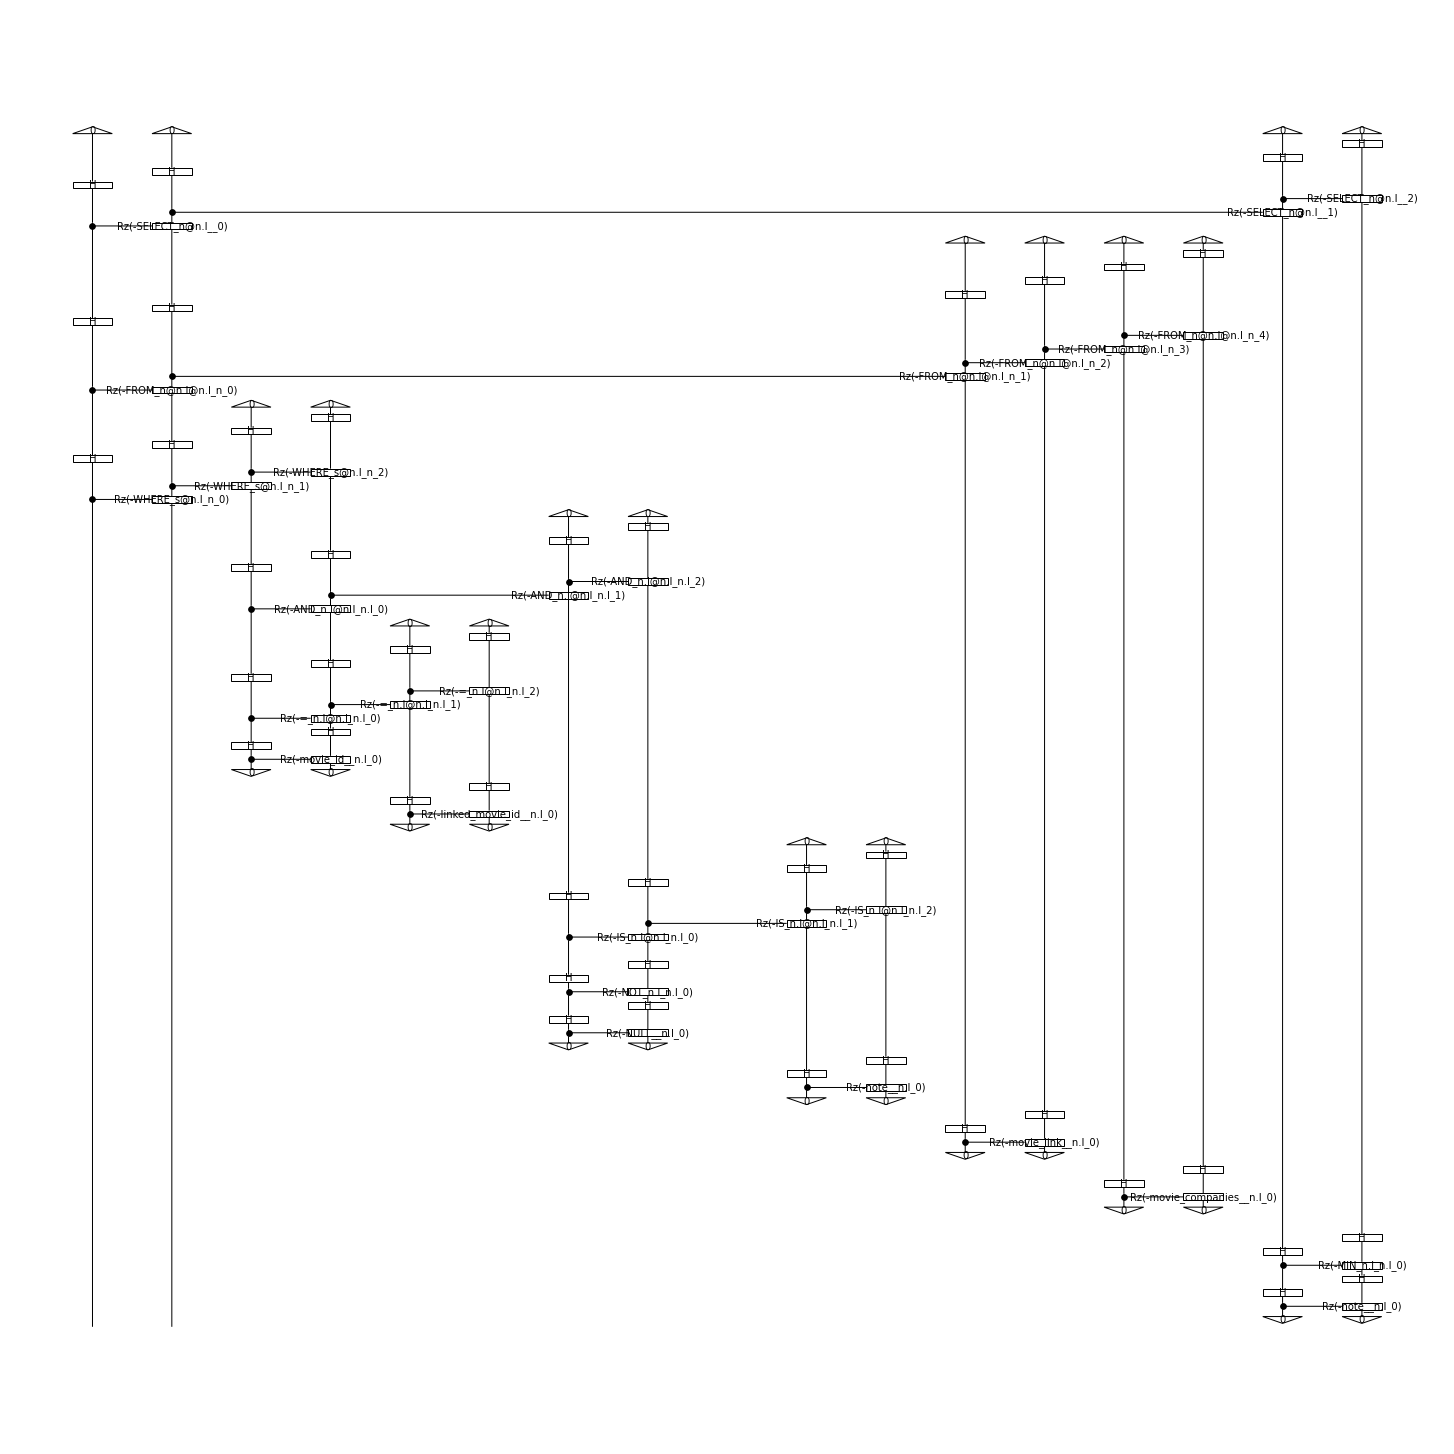

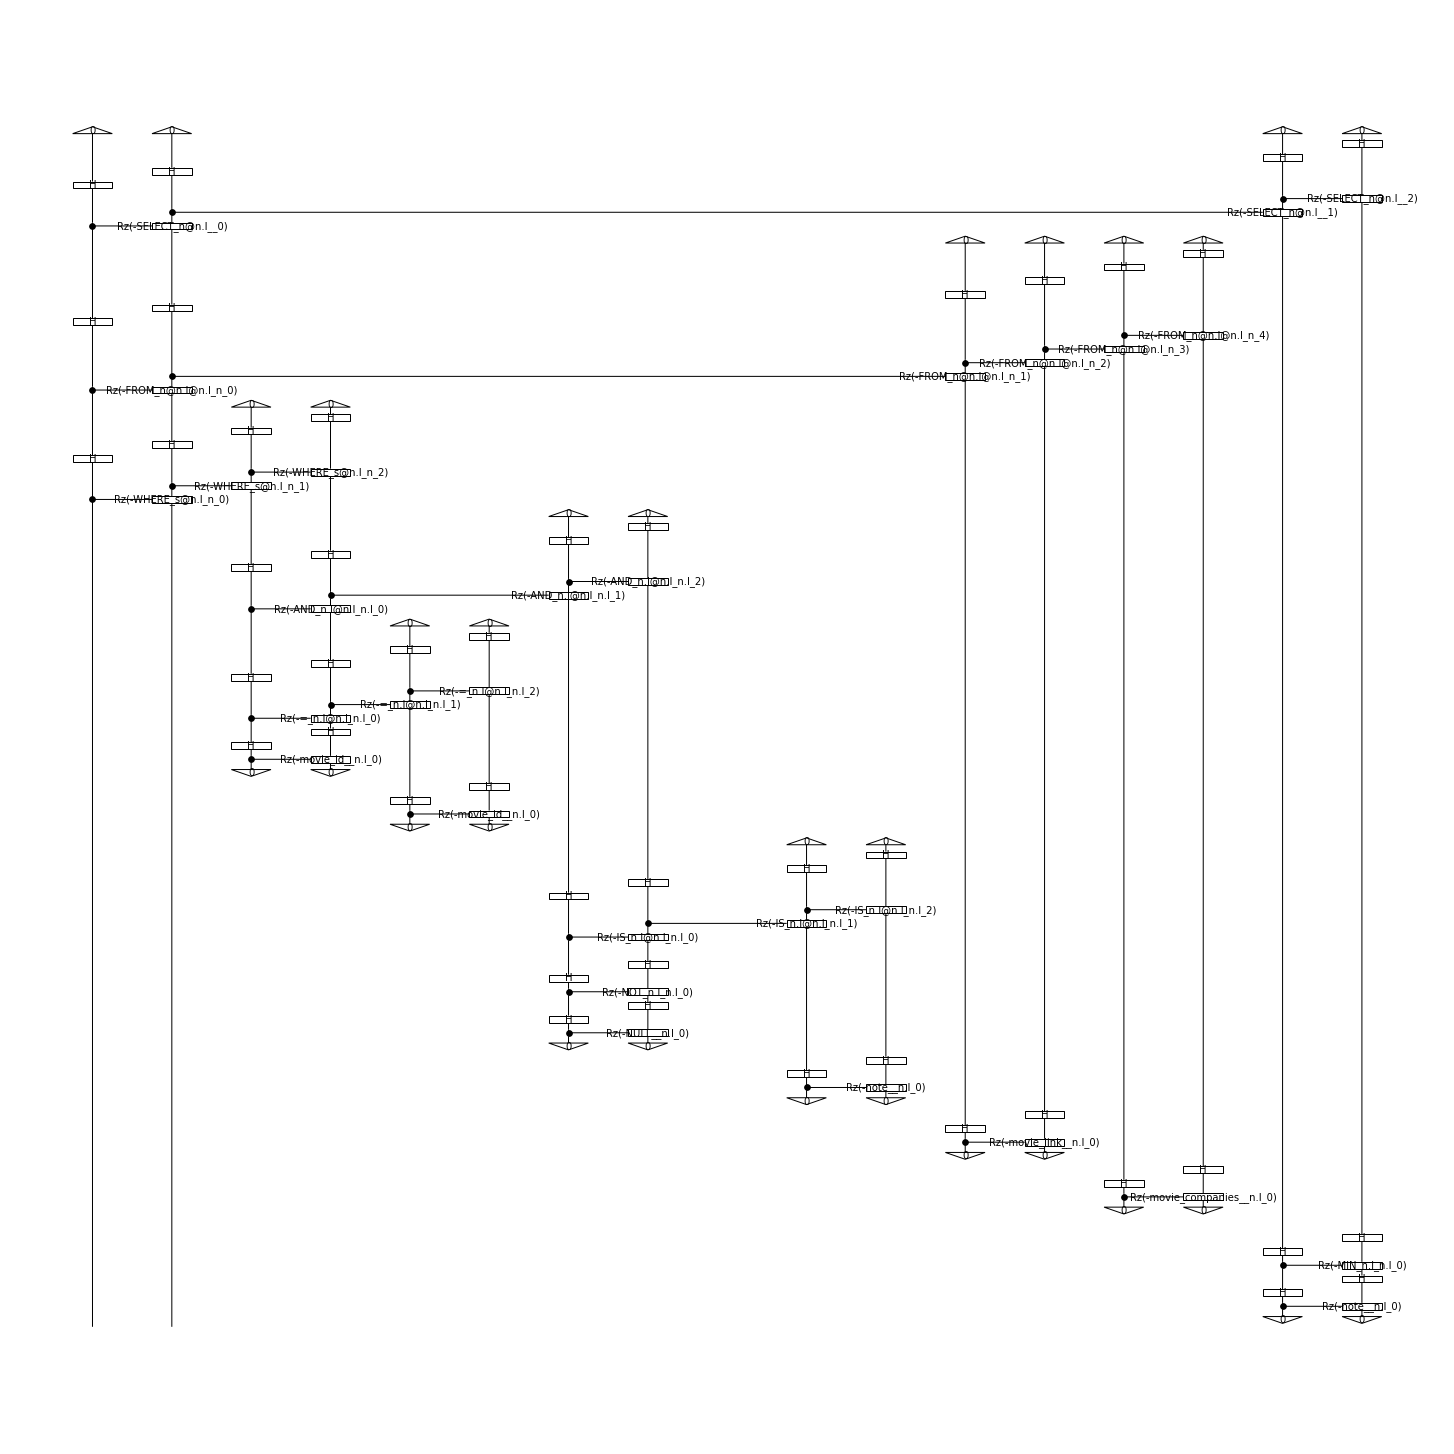

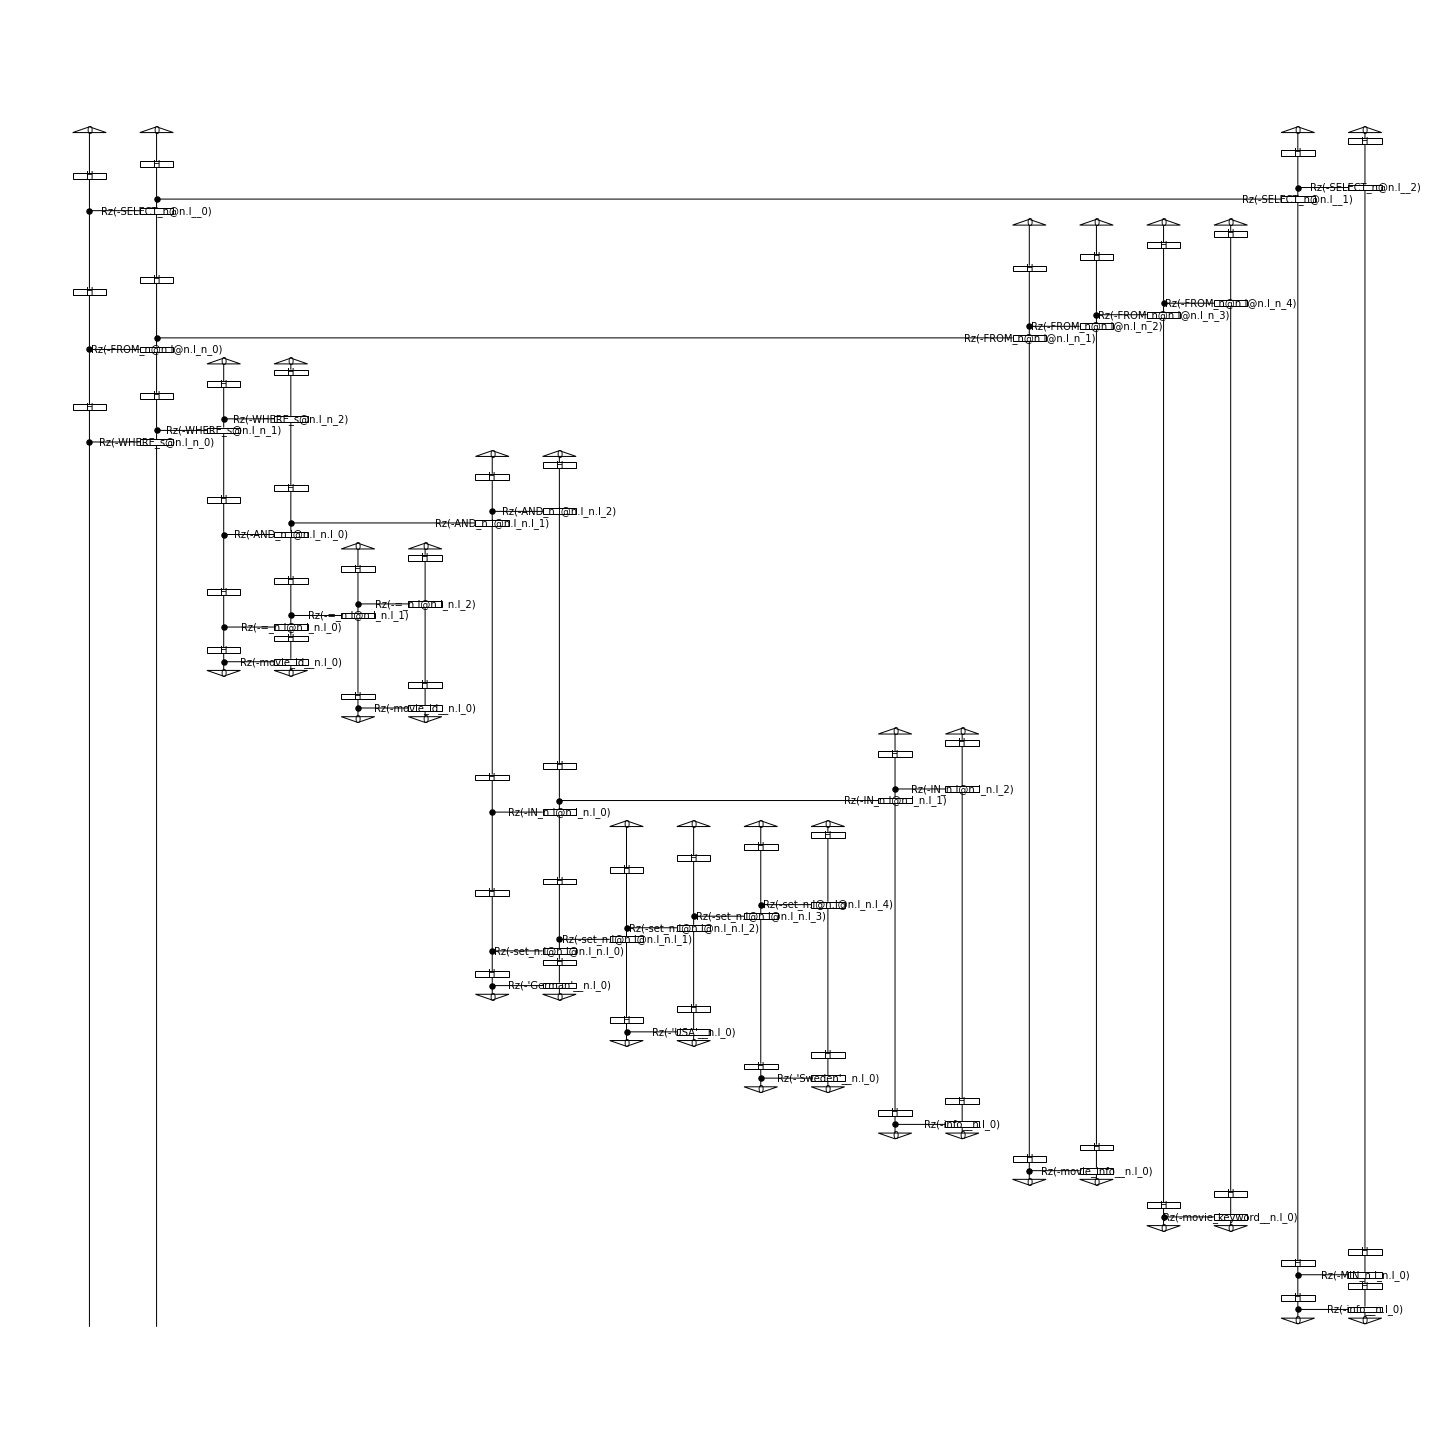

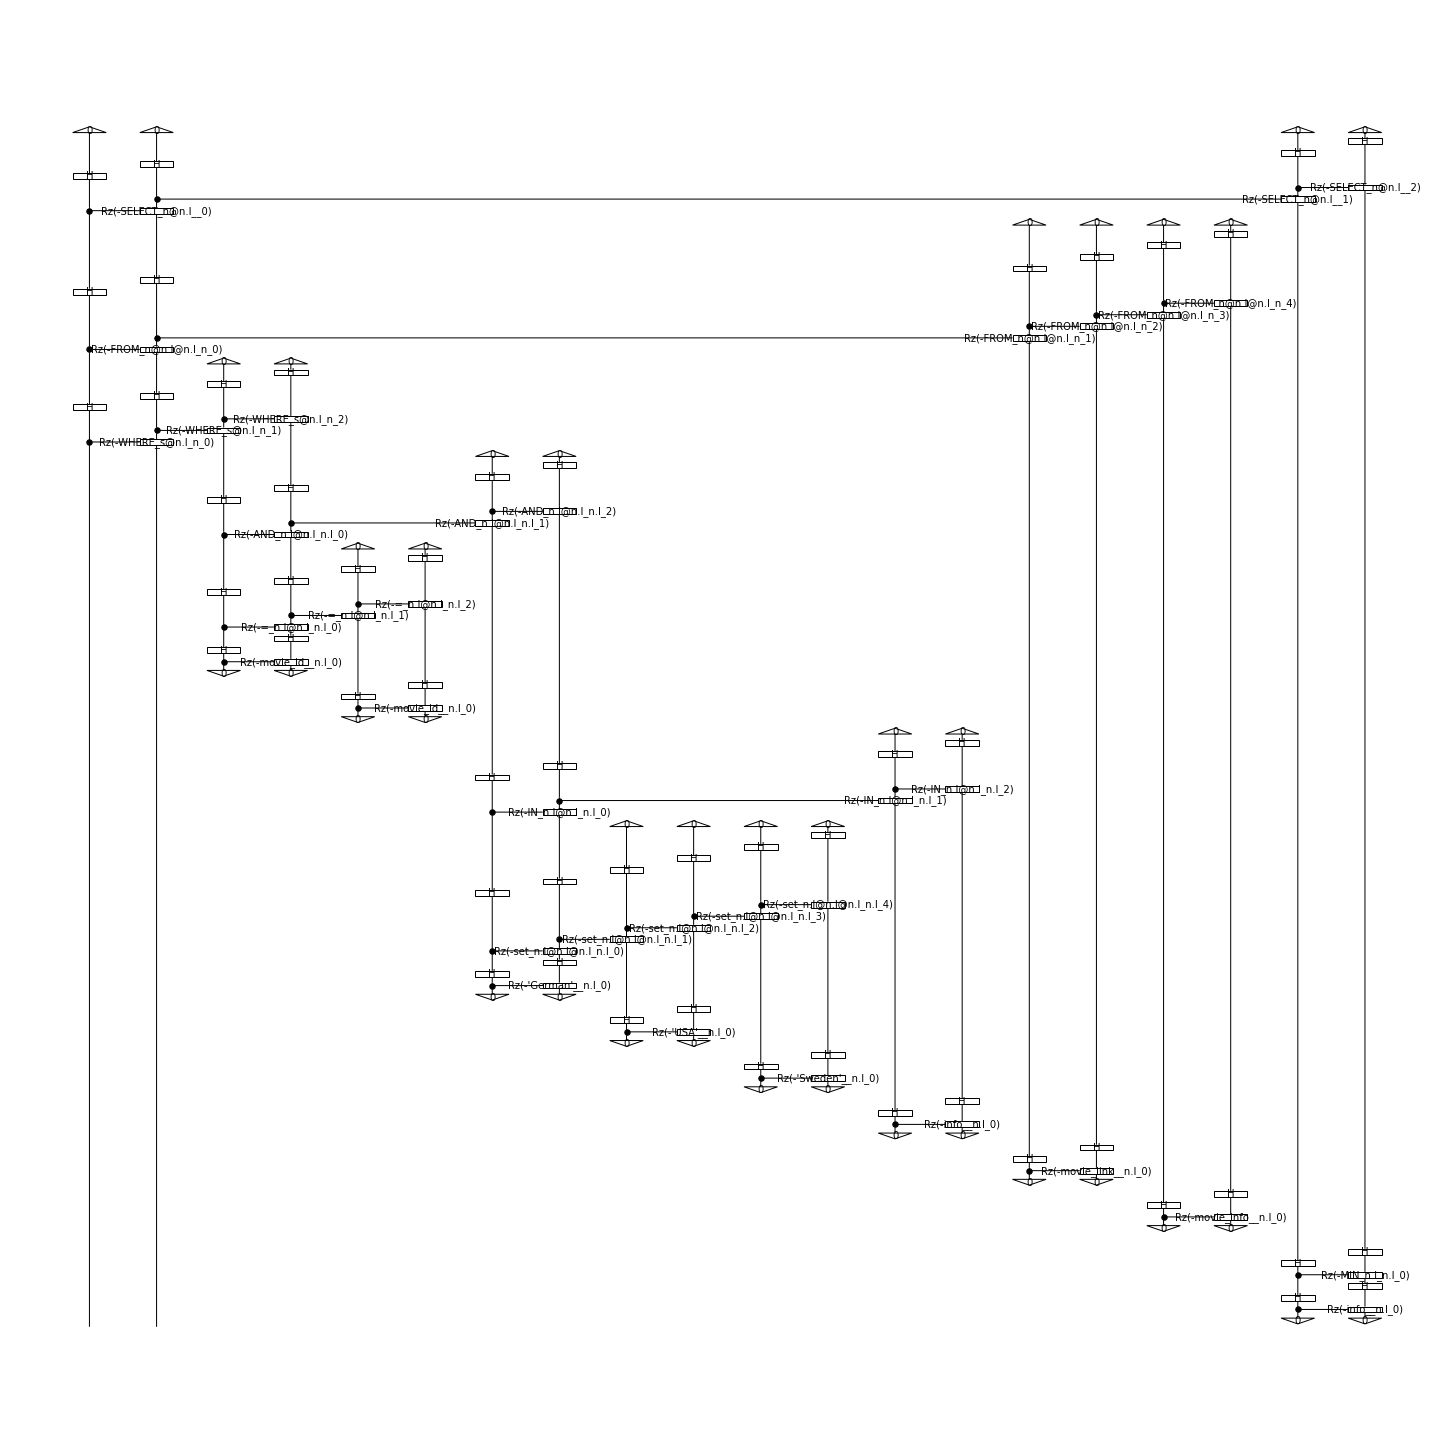

Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Total number of circuits:  29
Total number of variables:  58


In [16]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
validation_circuits_l = []

training_data_labels_l = []
test_data_labels_l = []
validation_data_labels_l = []

# Organize circuits and labels in correct order into two lists which will be input for training the model
for key in training_data_labels:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_data_labels:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])
    
for key in validation_data_labels:
    validation_circuits_l.append(validation_circuits[key])
    validation_data_labels_l.append(validation_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l + validation_circuits_l

for c in training_circuits_l:
    c.draw(figsize =(20,20))

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])
val_syms = set([sym for circuit in validation_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", test_syms.difference(train_syms))
print("Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", val_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len(train_syms))

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 3200
}

## Select the model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

In [6]:
model = TketModel.from_diagrams(training_circuits_l, backend_config=backend_config)
#model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
model.initialise_weights()

## Define loss function and evaluation metrics

In [7]:
eval_metrics = {"acc": acc}

In [8]:
a, c = calibrate(loss, np.array(model.weights), A = 0.01*EPOCHS)

 -- Learning rate: a / ((A + n) ^ alpha) with a = 16.09168294326651, A = 100.0, alpha = 0.602
 -- Perturbation: c / (n ^ gamma) with c = 0.2, gamma = 0.101


## Initialize the trainer and the datasets

In [9]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 1.0, 'c': 1.0, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

In [10]:
train_dataset = Dataset(training_circuits_l, training_data_labels_l)
val_dataset = Dataset(validation_circuits_l, validation_data_labels_l, shuffle=False)
test_dataset = Dataset(test_circuits_l, test_data_labels_l, shuffle=False)

## Train the model

In [ ]:
#trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)

## Visualize the training process and results

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

for e in model(test_circuits_l):
    print(e)
for e in test_data_labels_l:
    print(e)

# print test accuracy
test_acc = acc(model(test_circuits_l), test_data_labels_l)
print('Test accuracy:', test_acc)